# Clothes2Person

## Datasets:
https://github.com/shadow2496/VITON-HD?tab=readme-ov-file
11k pairs, with face (only lower body clothes, full body shot)
2k pairs, with face (only lower body clothes, full body shot)
datasource zalando

- 9k lower body (unfortunately only lower part of face visible (anonymized))
- 15k upper body (unfortunately only lower part of face visible (anonymized)) 
- 29k upper body (unfortunately only lower part of face visible (anonymized)) 
data source YOOX NET-A-PORTER


We use all data for training and use some new sampels for validation:
In-distribution Images from Zalando from the NEW tab (which should ensure these are new designs/ clothes the model has never seen)
Out of distribution images from Uniqlo from the NEW tab

The ControlNet architecture (https://arxiv.org/pdf/2302.05543):

The main idea of the ControlNet is to include a secondary input in addition to the main input for any model F. 
Then a frozen, locked, F(x, theta), and a copy of F(x, theta) (copy of the pretrained weights) are finetuned in conjunction to calculate y.
The layerwise activations of the copy are added through 1x1 convolutions to the main model. These convolutional layers are initialized at 0.
Thus initially, the whole model will compute using only F(x, theta), without the copy. This idea stabilizes the conditional finetuning approach: The weights of the initial F always stay locked and only the copied weights are finetuned in conjunction with the 1x1 convolutions:
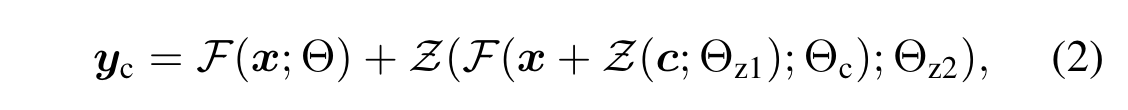

The authors apply the architecture to the Stable Diffusion architecture. In detail, only to the encoder and the middle part of U-Net component, which denoises the latents are copied. The duplicated encoder and middle part of the U-Net are added through skip connections with 1x1 convolutions to the middle part and decoder of the original U-Net. While the main U-Net is conditioned on the timestep and the encoded prompt, the new part which is finetuned can be conditioned on a image embedding C_f which is obtained by downscaling a conditional image by a small convolutional component with four layers from 512x512 to the size of the U-Net latents, 64x64. 

Working applications of ControlNet today are similar to the apple example, where the model is conditioned to follow a shape when composing a final image. Also, the main paper demonstrates how multiple conditions can be added through simple additions of the ControlNet outputs:
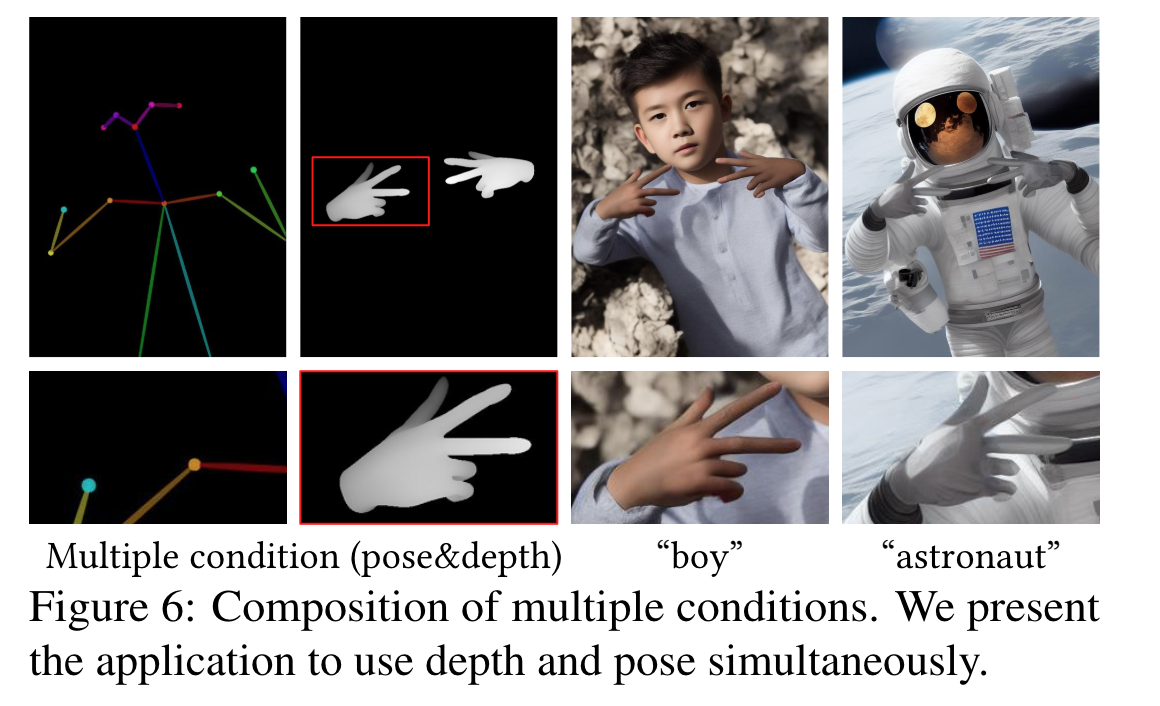

Some repository options for training ControlNet:
 - https://github.com/lllyasviel/ControlNet
    This is the official repository by one of the authors.
    Training is rather slow, but the author provides intuition on the training process.
    As observed over different training setups, ControlNet seems to have a point of convergence for the conventional ControlNet tasks like "depth-map2img", "lines2img" etc.: 
    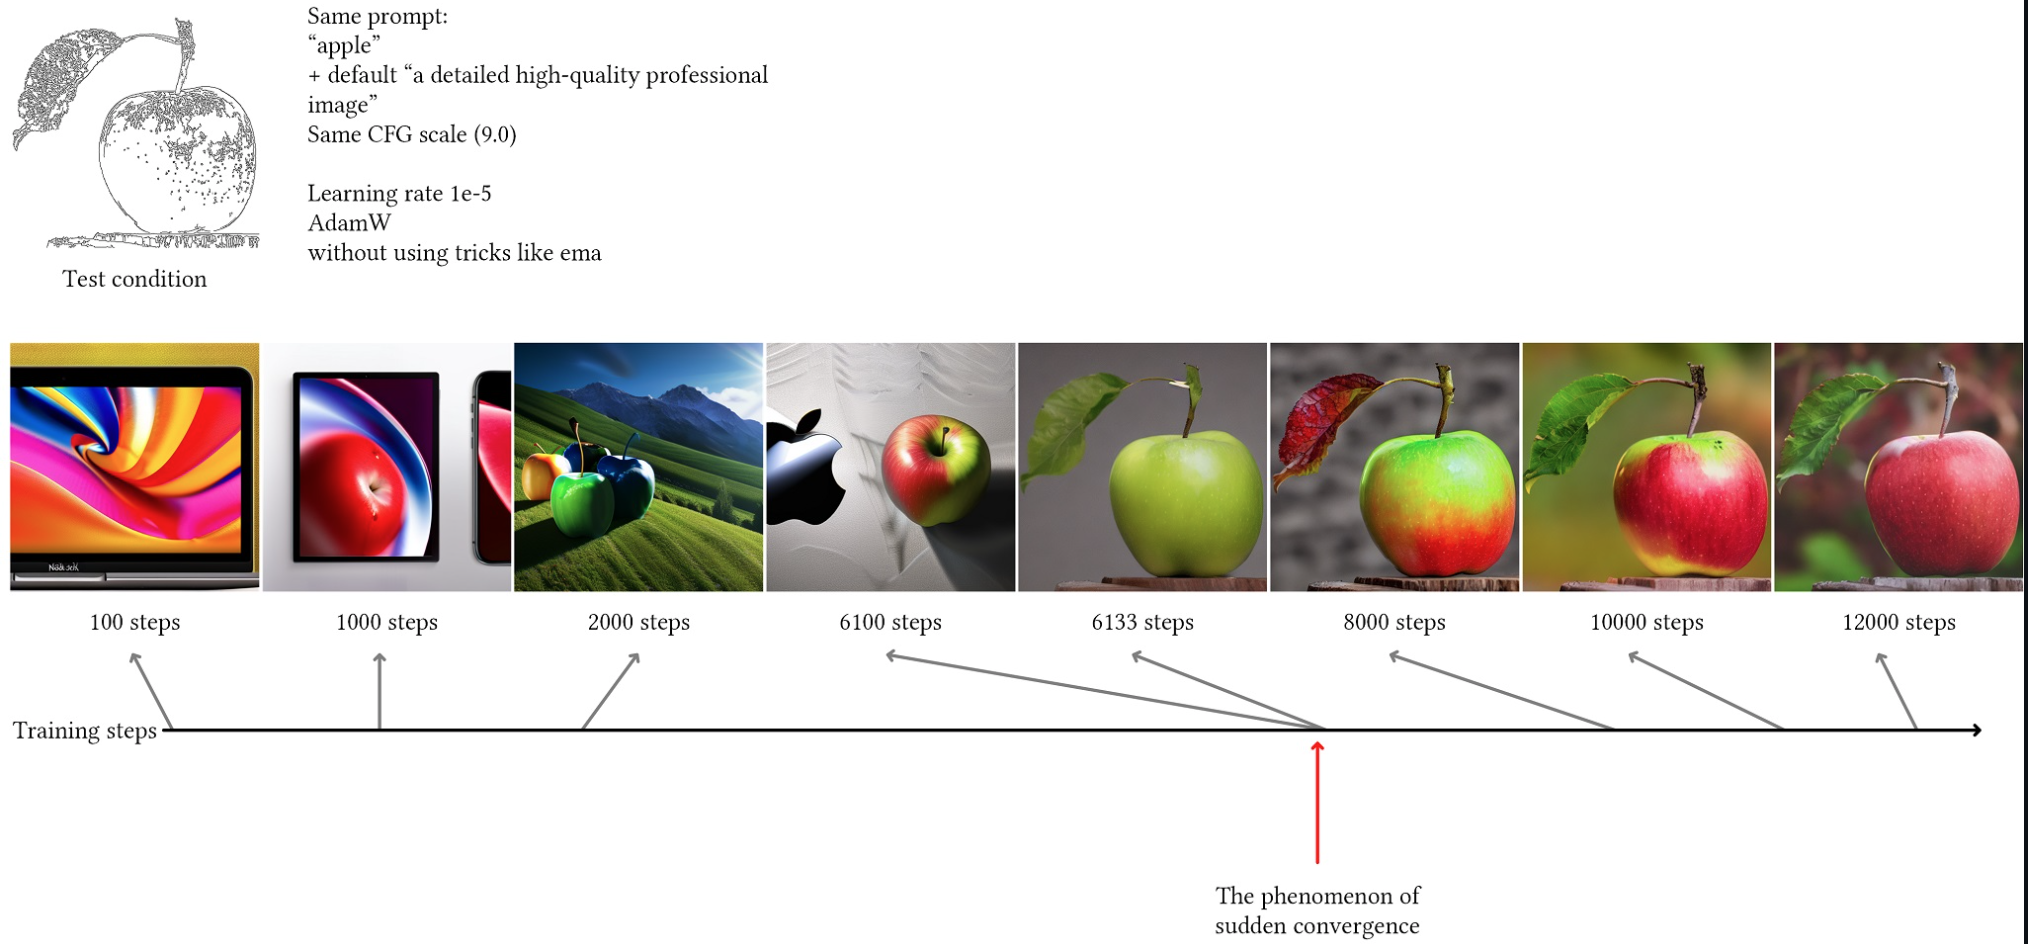 
    According to the author instead of training much further beyond the point of convergence it is better to train with larger batch size and a similar step amount to achieve more stable results: In this case training for 6000 steps (to the point of convergence) with doubled batchsize is better than training for 12000 steps with the original batch size.



The original ControlNet paper:

# Using the 16gb tutorial setup: 
# faster 9h/ 2.85s per iter
# Using 16gb + 12 gb --enable_xformers_memory_efficient_attention --set_grads_to_none is a lot slower
# Steps:   1%|        | 100/12500 [04:46<9:48:04,  2.85s/it, loss=0.0195, lr=1e-5
# so we use 16gb config
# use 2 T4 gpu:
# Steps:   1%|         | 13/2084 [03:11<8:16:03, 14.37s/it, loss=0.00271, lr=1e-5]
# can increase batchsize to 3 per node and 4 gradient accumulation steps: effectively batch size of 24
# - the code can achieve the speedup because of bitsandbites 8bitAdam, where we trade off speed for lower VRam usage
# - Gradient accumulation, only the compute graph is stored for each intermediate batch, after 4 batches gradients are jointly "backpropagated".
# -  therefore during the forward pass, only 1 of 4 batches is in memory simulatneously, which reduces the maximum memory usage and allows to train with larger effective batch sizes.
# According to the user https://github.com/lllyasviel (author of the original controlnet implementation for stable diffusion), training on larger batch sizes is prefered 
# to training for more steps. 
# batch size 24 is already 
# total of 50000 images,
# grad accumulation: 12500 steps, 
# 2 gpu: 6250 steps: 
# bs 3 instead of 1: 2084 steps


As reference, the repository https://github.com/lllyasviel/ControlNet is used. 

## Data Preprocessing
### Merging Viton HD and Dresscode datasets
We hope that the combination of both datasets will help the model to create higher quality output:
- The Viton HD lacks lower body examples, which the Dresscode dataset provides.
- The Dresscode datasets model faces are cut halfway (possibly for anonymization purposes) which the Viton HD dataset provides in full shot.

One strategy to prevent the model from associating spurious information from the clothes images with the specifics of both datasets respectively (e.g. face is (not) cut off), is to include these facts through the clip encoder through text.
- Therefore, the model can learn to associate the fact that the face is (not) cut of with the text "face (not) in frame". Since we desire the face to be in frame, during inference we can use the appropriate text.
- Similarly, describing the output image with text, except for the clothing which is supplied as input image, could help the model to learn associations more appropriately. This is one variant we experiment with. Text descriptions can be added to the dataset with OpenAI's BLIP or CLIP

In [50]:
from PIL import Image
import os 
import pandas as pd  
import shutil 
from tqdm.auto import tqdm
dataset_dir = './dataset'
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(dataset_dir+'/clothes', exist_ok=True)
os.makedirs(dataset_dir+'/persons', exist_ok=True)

# test_pairs = pd.read_csv('zalando-hd-resized/test_pairs.txt', delimiter=' ', header=None)
# test_pairs.columns = ['clothes', 'persons']

# train_pairs = pd.read_csv('zalando-hd-resized/train_pairs.txt', delimiter=' ', header=None)
# test_pairs.columns = ['clothes', 'persons']


# all_pairs = pd.concat([test_pairs, train_pairs])
# # conflicts?
# print('No conflicts:')
# print(len(all_pairs) == len(set(all_pairs[0].values)) and len(all_pairs) == len(set(all_pairs[1].values)))

for file in tqdm(os.listdir('zalando-hd-resized/train/cloth')):
    if file.endswith('.jpg'):
        shutil.copy('zalando-hd-resized/train/cloth/'+file, dataset_dir+'/clothes/'+'vitonhdtrain_upperbody_'+file)

for file in tqdm(os.listdir('zalando-hd-resized/train/image')):
    if file.endswith('.jpg'):
        shutil.copy('zalando-hd-resized/train/image/'+file, dataset_dir+'/persons/'+'vitonhdtrain_upperbody_'+file)

for file in tqdm(os.listdir('zalando-hd-resized/test/cloth')):
    if file.endswith('.jpg'):
        shutil.copy('zalando-hd-resized/test/cloth/'+file, dataset_dir+'/clothes/'+'vitonhdtest_upperbody_'+file)

for file in tqdm(os.listdir('zalando-hd-resized/test/image')):
    if file.endswith('.jpg'):
        shutil.copy('zalando-hd-resized/test/image/'+file, dataset_dir+'/persons/'+'vitonhdtest_upperbody_'+file)


100%|██████████| 2032/2032 [00:01<00:00, 1876.72it/s]


In [51]:
# check if all files are copied
set(os.listdir('dataset/clothes')) == set(os.listdir('dataset/persons')) 
print('Number of pairs:', len(os.listdir('dataset/clothes')))

Number of pairs: 13679


In [52]:
# DressCode, check for each base name there are two iamges
counts = {}
for path in ['DressCode/dresses/images', 'DressCode/lower_body/images','DressCode/upper_body/images']:
    print(path)
    for p in os.listdir(path+'/'):
        ps = p.split('_')[0]
        if ps not in counts:
            counts[ps] = 1
        else:
            counts[ps] = 2 
    for k in counts:
        if counts[k] != 2:
            print(k) 


DressCode/dresses/images
DressCode/lower_body/images
DressCode/upper_body/images


In [53]:
# DressCode, check for each base name there are two images and copy the images to the dataset
for path in ['DressCode/dresses/images', 'DressCode/lower_body/images','DressCode/upper_body/images']:
    print(path)
    for p in tqdm(os.listdir(path+'/')):
        ps = p.split('_')[0]

        is_clothing = p.split('_')[1]
        type_ = path.split('/')[1]
        type_ = type_.replace('_','')
        if is_clothing =='1.jpg':
            shutil.copy(path+'/'+p, dataset_dir+'/clothes/'+'dresscode_'+type_+'_'+ps+'.jpg')
        elif is_clothing =='0.jpg':
            shutil.copy(path+'/'+p, dataset_dir+'/persons/'+'dresscode_'+type_+'_'+ps+'.jpg')
        else:
            raise ValueError('Unknown type')

DressCode/dresses/images


100%|██████████| 58956/58956 [00:32<00:00, 1816.58it/s]


DressCode/lower_body/images


100%|██████████| 17902/17902 [00:10<00:00, 1761.35it/s]


DressCode/upper_body/images


100%|██████████| 30726/30726 [00:17<00:00, 1719.01it/s]


In [94]:
# check if all files are copied
set(os.listdir('dataset/clothes')) == set(os.listdir('dataset/persons')) 
print('Number of pairs:', len(os.listdir('dataset/clothes')))

Number of pairs: 67471


In [ ]:
# Best inference settings are provided by the author https://civitai.com/models/25694/epicrealism

# Prompt: simple explanation of the image (try first without extra keywords)
# Negative: "cartoon, painting, illustration, (worst quality, low quality, normal quality:2)"
# Steps: >20 (if image has errors or artefacts use higher Steps)
# CFG Scale: 5 (higher config scale can lose realism, depends on prompt, sampler and Steps)
# Sampler: Any Sampler (SDE, DPM-Sampler will result in more realism)
# Size: 512x768 or 768x512
# Hires upscaler: 4x_NMKD-Superscale-SP_178000_G (Denoising: 0.35, Upscale: 2x)

### Resizing and creating DataLoader

Images need to be resized to multiples of 64. 
Since standard Stable Diffusion (SD) sizes are 512x512 and 768x512, we resize to 768x512 from 1024x768. <br>
The image is resized to match the height of 768 and the left and right are cut to match the smaller width of 512.

In [ ]:
import cv2

ratios = {}
for dir in ['dataset/clothes', 'dataset/persons']:
    for img_name in tqdm(os.listdir(dir)):
        img_path = os.path.join(dir, img_name)
        img = cv2.imread(img_path)
        # ratio = img.shape[1] / img.shape[0]
        reso_name = str(img.shape[0])+'x'+str(img.shape[1])
        if reso_name not in ratios:
            ratios[reso_name] = 1
        else:
            ratios[reso_name] += 1
        # print(ratio)
        

In [29]:
ratios

{'1024x768': 134942}

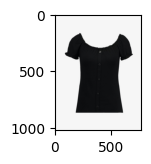

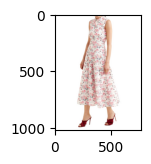

In [83]:
import cv2
vitionhd_sample = cv2.imread('dataset/clothes/vitonhdtrain_upperbody_14298_00.jpg')
dresscode_sample = cv2.imread('dataset/persons/dresscode_dresses_020735.jpg')
# show image, in ipython output
# cv2.imshow('image', img)

from matplotlib import pyplot as plt
import numpy as np
import cv2
def show_image(img, size=(1.5, 1.5)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

show_image(vitionhd_sample)
show_image(dresscode_sample)

Height: 768, width:  576.0
Resized image openCV


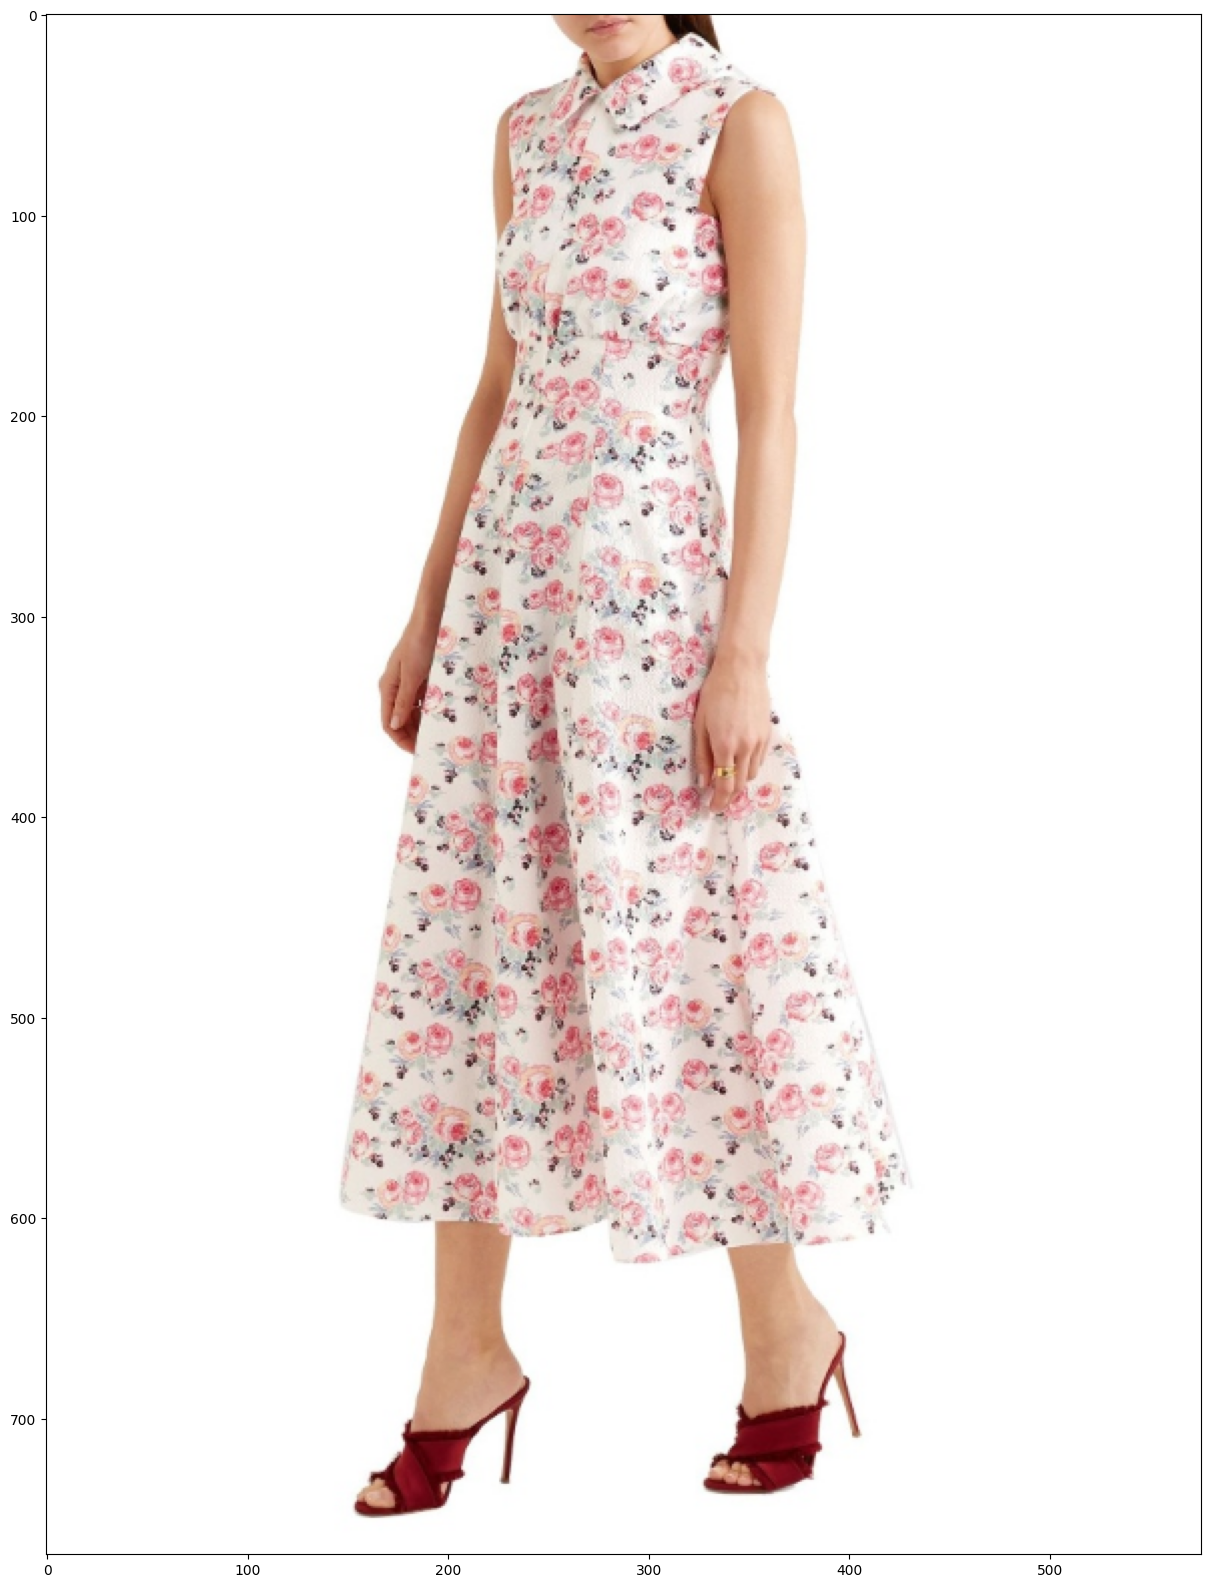

Resized image PIL


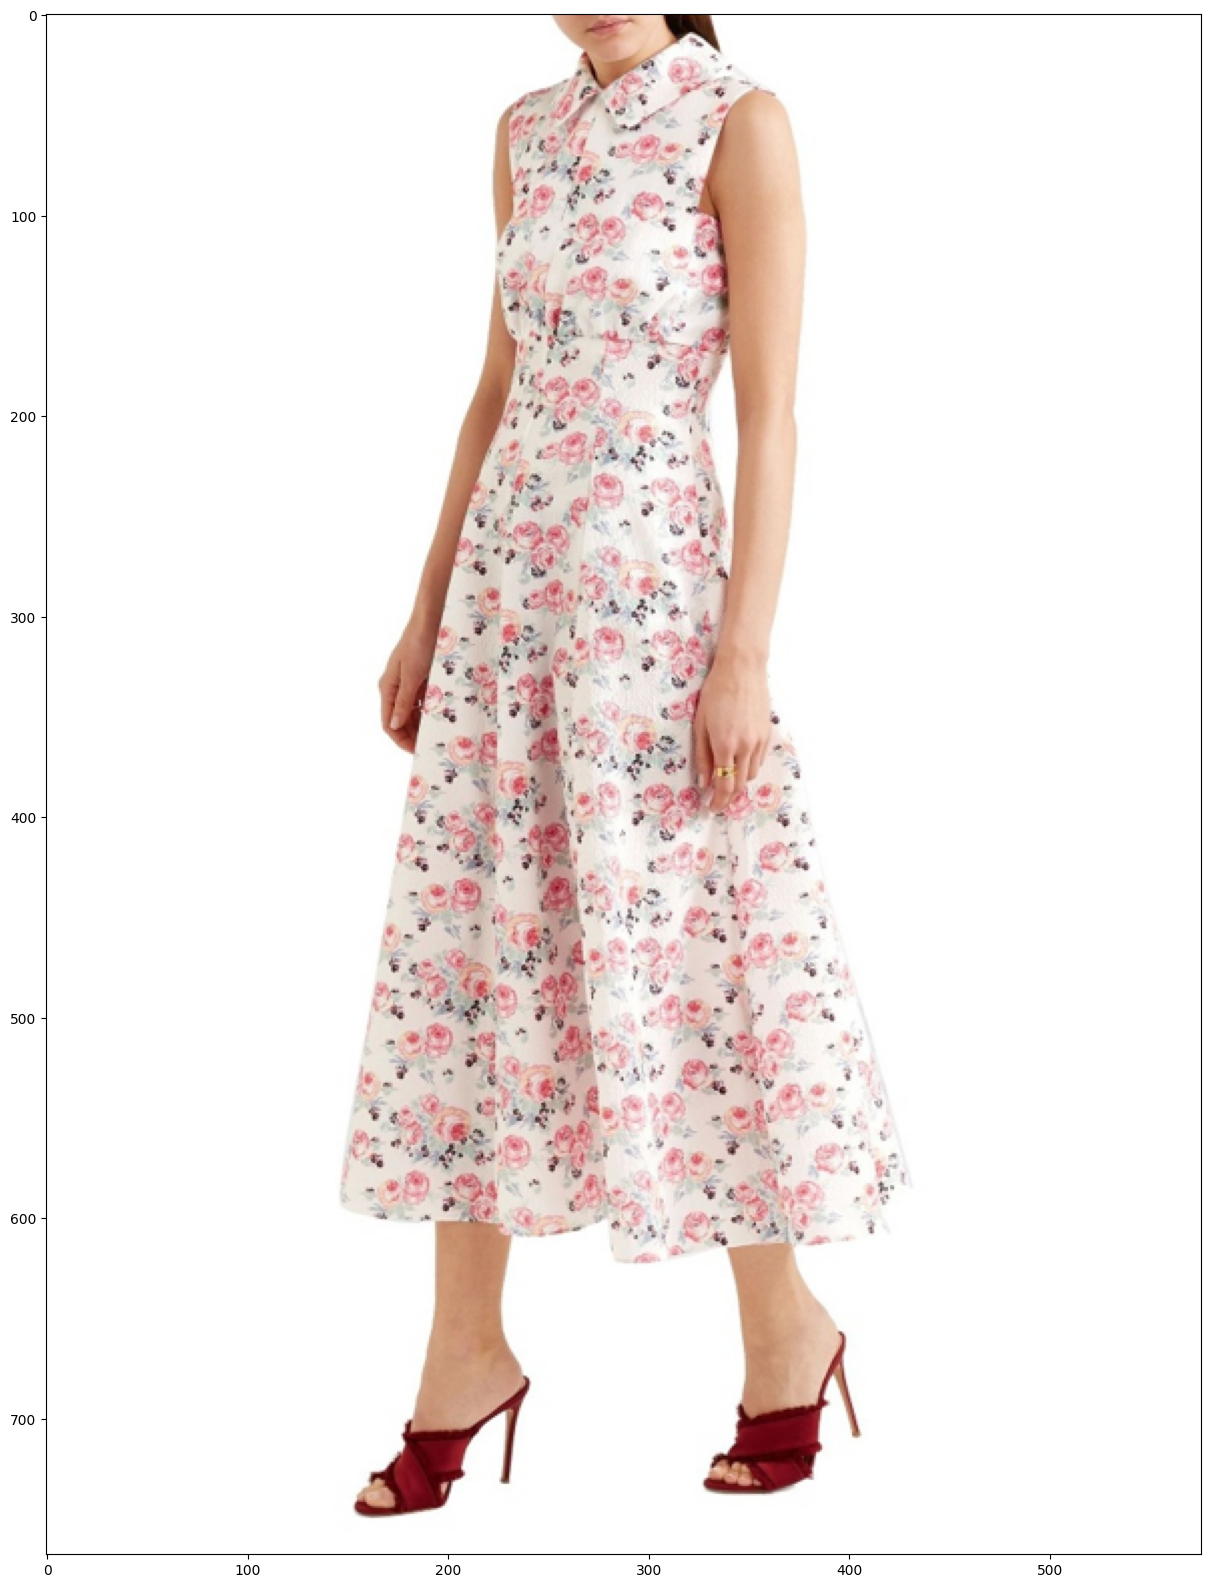

Center pixel 288
Resized image with width 512
Cropped image


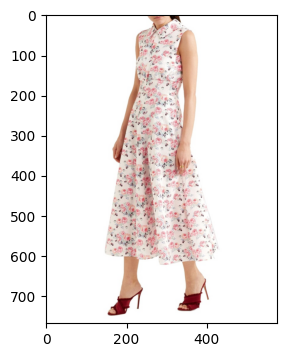

-->


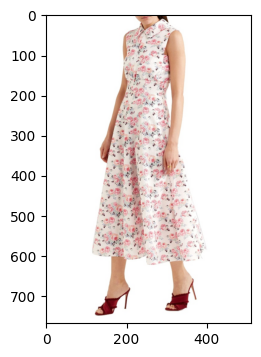

Width: 512 Height: 768


In [91]:
# using PIL instead of open cv for resizing, the edges seem less rough
from PIL import Image

img = dresscode_sample
width, height = img.shape[1], img.shape[0]
assert width == 768 and height == 1024
width = (768/1024)*768
print('Height: 768, width: ',width)
img = cv2.resize(dresscode_sample, (int(width), 768))
print('Resized image openCV')
show_image(img, size=(20, 20))

# same with PIL
img = Image.open('dataset/persons/dresscode_dresses_020735.jpg')
img = img.resize((int(width), 768))
print('Resized image PIL')
show_image(np.array(img)[:,:,::-1], size=(20, 20))

center_x = img.width//2
print('Center pixel', center_x)
print('Resized image with width 512')
cropped_img = img.crop((center_x-256, 0, center_x+256, 768))
print('Cropped image')
show_image(np.array(img)[:,:,::-1], size=(4, 4))
print('-->')
show_image(np.array(cropped_img)[:,:,::-1], size=(4, 4))
print('Width:', cropped_img.width, 'Height:', cropped_img.height)


In [96]:
# resize images
input_dirs = ['dataset/clothes', 'dataset/persons']
temp_dirs = ['dataset/temp_clothes', 'dataset/temp_persons']

for temp_dir in temp_dirs:
    os.makedirs(temp_dir, exist_ok=True)

for input_dir, temp_dir in zip(input_dirs, temp_dirs):
    for filename in tqdm(os.listdir(input_dir)):
    
        file_path = input_dir+'/'+ filename
        img = Image.open(file_path)
        width, height = img.size
        assert width == 768 and height == 1024
        width = (768/1024)*768
        img = img.resize((int(width), 768))
        center_x = img.width // 2
        cropped_img = img.crop((center_x-256, 0, center_x+256, 768))
        cropped_img.save(temp_dir+'/'+filename)

for input_dir, temp_dir in zip(input_dirs, temp_dirs):
    old_dir = 'old_' + os.path.basename(input_dir)
    new_dir = os.path.basename(temp_dir).replace('temp_', '')

    os.rename(input_dir, 'dataset/'+old_dir)
    os.rename(temp_dir, 'dataset/'+new_dir)



100%|██████████| 67471/67471 [12:58<00:00, 86.66it/s]  


### Creating image captions
The captioning code is run on Kaggle, because inference for the best captions is slow, it is run on multiple accounts.
We modify the code and utilize threading in order to run inference in parallel on both gpus Kaggle provides. Maybe running two inferences on one GPU could speed up the process even further.

In [ ]:
start_at = 0
end_at = start_at+2000

In [ ]:
!pip install clip-interrogator==0.6.0 -q

In [ ]:
!unzip -q /kaggle/input/getcontrolnetcaptions/persons.iamazip -d ./ 

In [ ]:
import torch
num_devices = torch.cuda.device_count()
if torch.cuda.is_available():
    print(f"CUDA is available. Number of devices: {num_devices}")
    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

CUDA is available. Number of devices: 2
Device 0: Tesla T4
Device 1: Tesla T4


In [ ]:
from clip_interrogator import Config, Interrogator
def new_init(self, config: Config):
    print('Overwrite')
    self.config = config
    self.device = config.device
    self.dtype = torch.float32 # torch.float16 if 'cuda' in self.device else torch.float32 # modified
    self.caption_offloaded = True
    self.clip_offloaded = True
    self.load_caption_model()
    self.load_clip_model()
        
        
Interrogator.__init__ = new_init

In [ ]:
import os
if os.path.exists('/kaggle/input/getcontrolnetcaptions/captions.csv'):
    !cp /kaggle/input/getcontrolnetcaptions/captions.csv /kaggle/working/

In [ ]:
config = Config(clip_model_name="ViT-L-14/openai", device='cpu', quiet=True)
ci = Interrogator(config)
del ci

In [ ]:
import os
import threading
import csv
from PIL import Image
from tqdm.notebook import tqdm

input_folder = "/kaggle/working/persons"
output_file = "/kaggle/working/captions.csv"

device_ids = [0, 1] 
lock = threading.Lock()
images = [f for f in os.listdir(input_folder) if f.lower().endswith(('jpg', 'jpeg'))]

# Create the CSV file with a header if it doesn't exist
if not os.path.exists(output_file):
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "caption"])
        
    
else:
    with open(output_file, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  
        csv_filenames = [row[0] for row in reader]
        print('Images before:',len(images))
        images = [f for f in images if f not in csv_filenames]
        print('After before:',len(images))
    

def process_images(images, device_id, progress_bar):
    config = Config(clip_model_name="ViT-L-14/openai", device='cuda:'+str(device_id), quiet=True)
    ci = Interrogator(config)

    for image_name in images:
        output_exists = False
        with lock:
            with open(output_file, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                if any(row[0] == image_name for row in reader):
                    output_exists = True
        if output_exists:
            progress_bar.update(1)
            continue

        image_path = os.path.join(input_folder, image_name)
        image = Image.open(image_path)
        caption = ci.interrogate(image)

        with lock:
            with open(output_file, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([image_name, caption])
                csvfile.flush()
            progress_bar.update(1)

image_parts = [images[::2]+images[1::2], images[1::2]+images[::2]]
image_parts[0] = image_parts[0][start_at:end_at]
image_parts[1] = image_parts[1][start_at:end_at]

progress_bars = [tqdm(total=len(part), desc=f"GPU {i}") for i, part in enumerate(image_parts)]

threads = [
    threading.Thread(target=process_images, args=(image_parts[0], device_ids[0], progress_bars[0])),
    threading.Thread(target=process_images, args=(image_parts[1], device_ids[1], progress_bars[1]))
]

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

for progress_bar in progress_bars:
    progress_bar.close()

#### Processing the captions
1. Clean the captions
2. Remove parts of captions which correspond to the clothing item which will be supplied as image input to the ControlNet:
    1. Use spacy to split each single tag into logical blocks
    2. Compare each block with the image of the clothing using CLIP to filter the appropriate ones out <br>
    (The alternative of applying an LLM is impractical, because answers are not formatted correctly, or the model is imprecise in returning the captions)

In [2]:
import pandas as pd 
captions = pd.read_csv('captions.csv')

# Some mistakes by the model:
remove = '😭 🤮 💕 🎀', '🎀 🍓 🧚',' pregnant,', 'pregnant'
for r in remove:
    captions['caption'] = captions['caption'].str.replace(r, '')
    
captions.head(3)

filename  \
0         dresscode_dresses_033203.jpg   
1  vitonhdtrain_upperbody_09726_00.jpg   
2  vitonhdtrain_upperbody_08957_00.jpg   

                                             caption  
0  a woman in a blue and orange dress with a clut...  
1  a woman wearing a white and black striped top ...  
2  a woman wearing a pink shorts and a zebra prin...

Filename: dresscode_dresses_033203.jpg


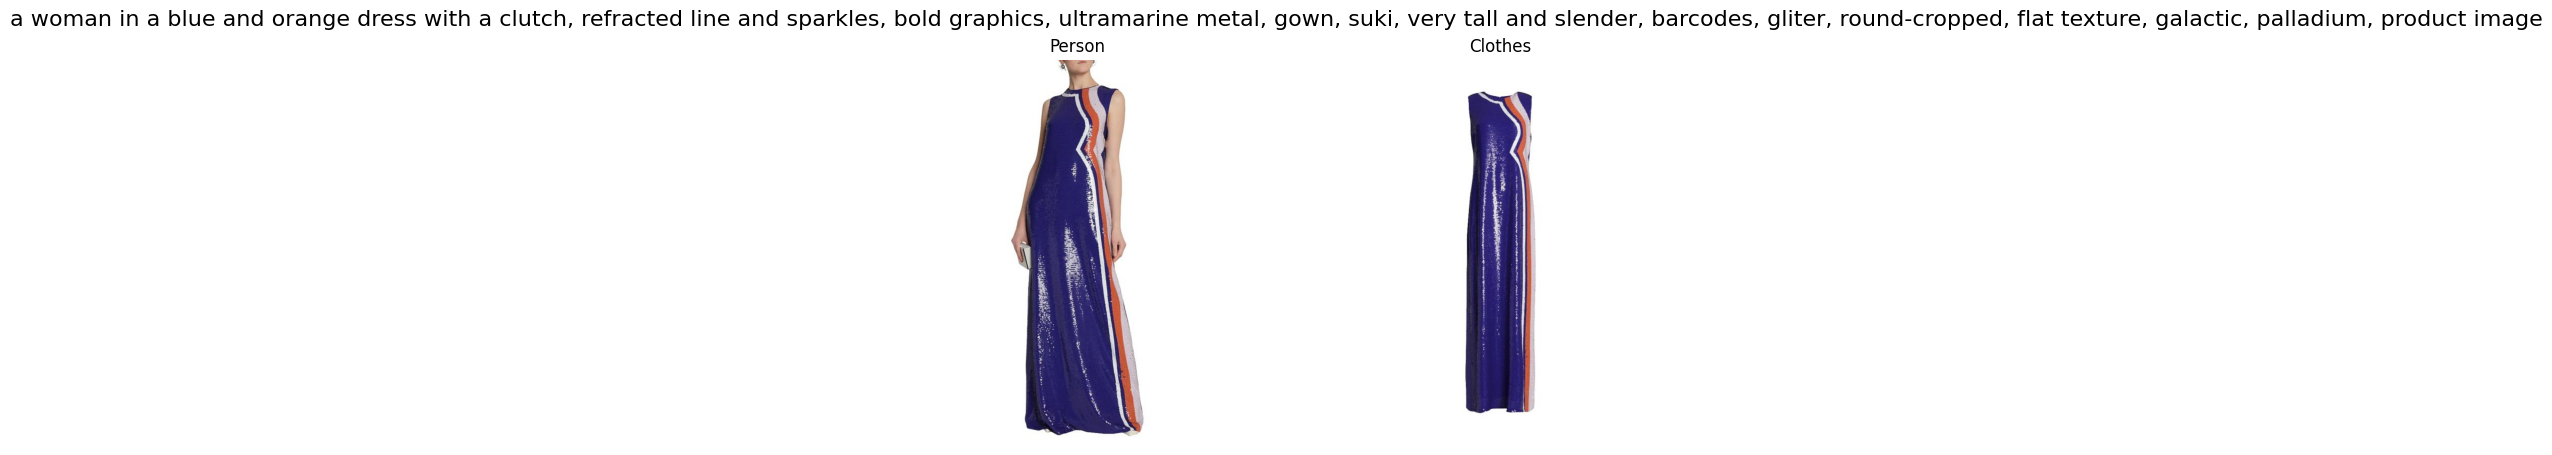


Filename: vitonhdtrain_upperbody_09726_00.jpg


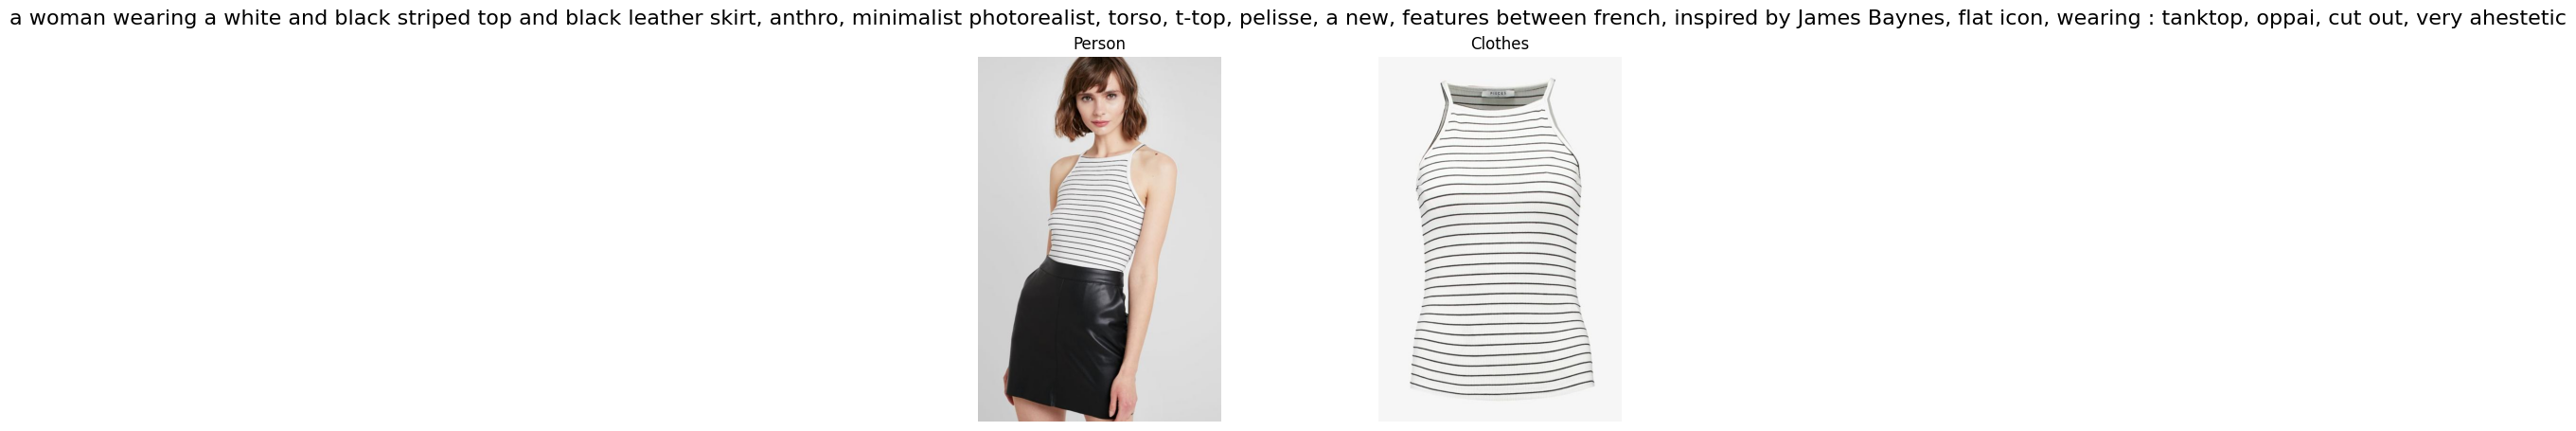


Filename: vitonhdtrain_upperbody_08957_00.jpg


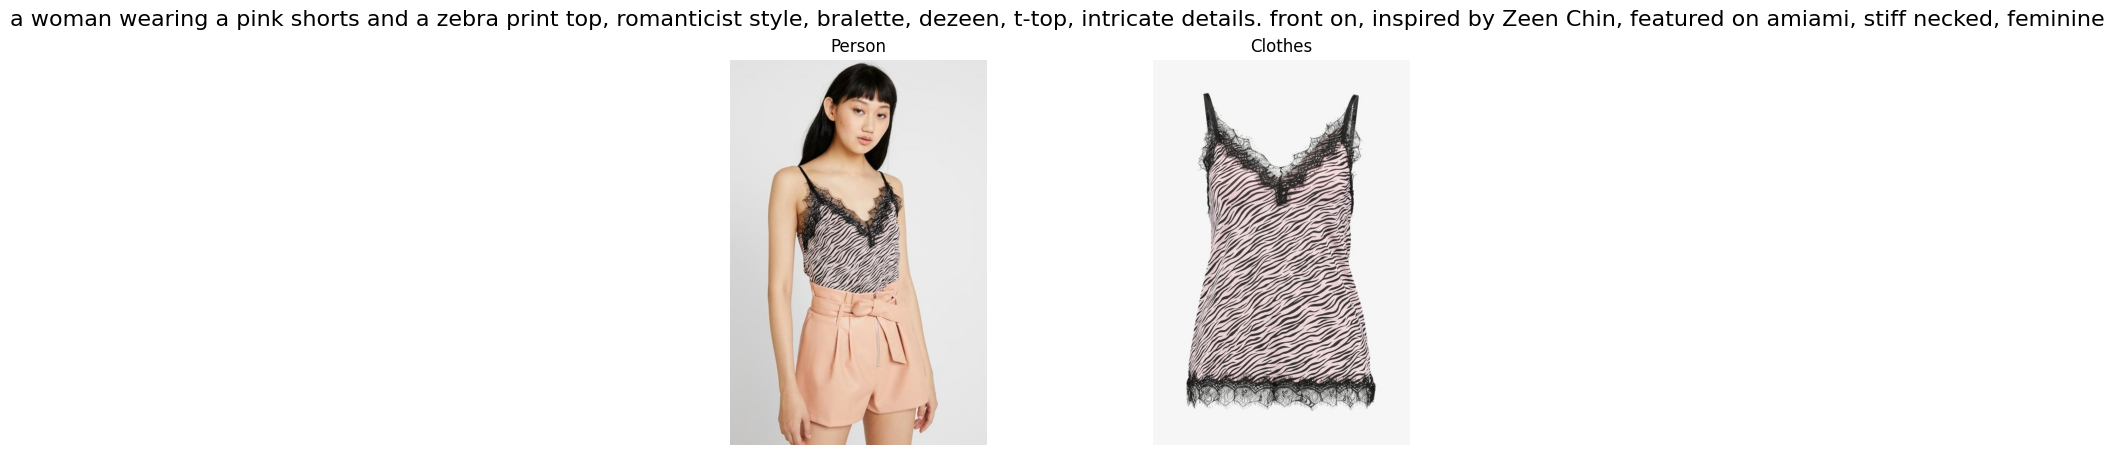


Filename: dresscode_upperbody_048951.jpg


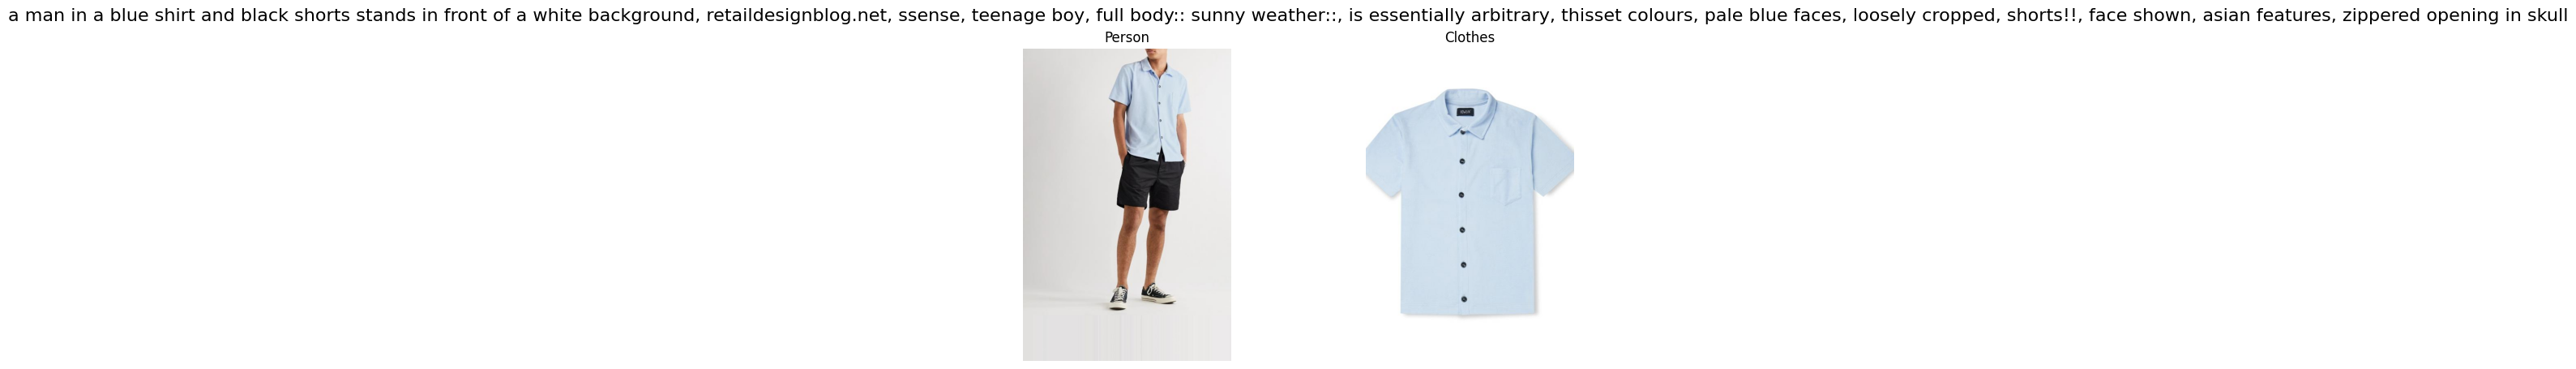


Filename: dresscode_upperbody_012135.jpg


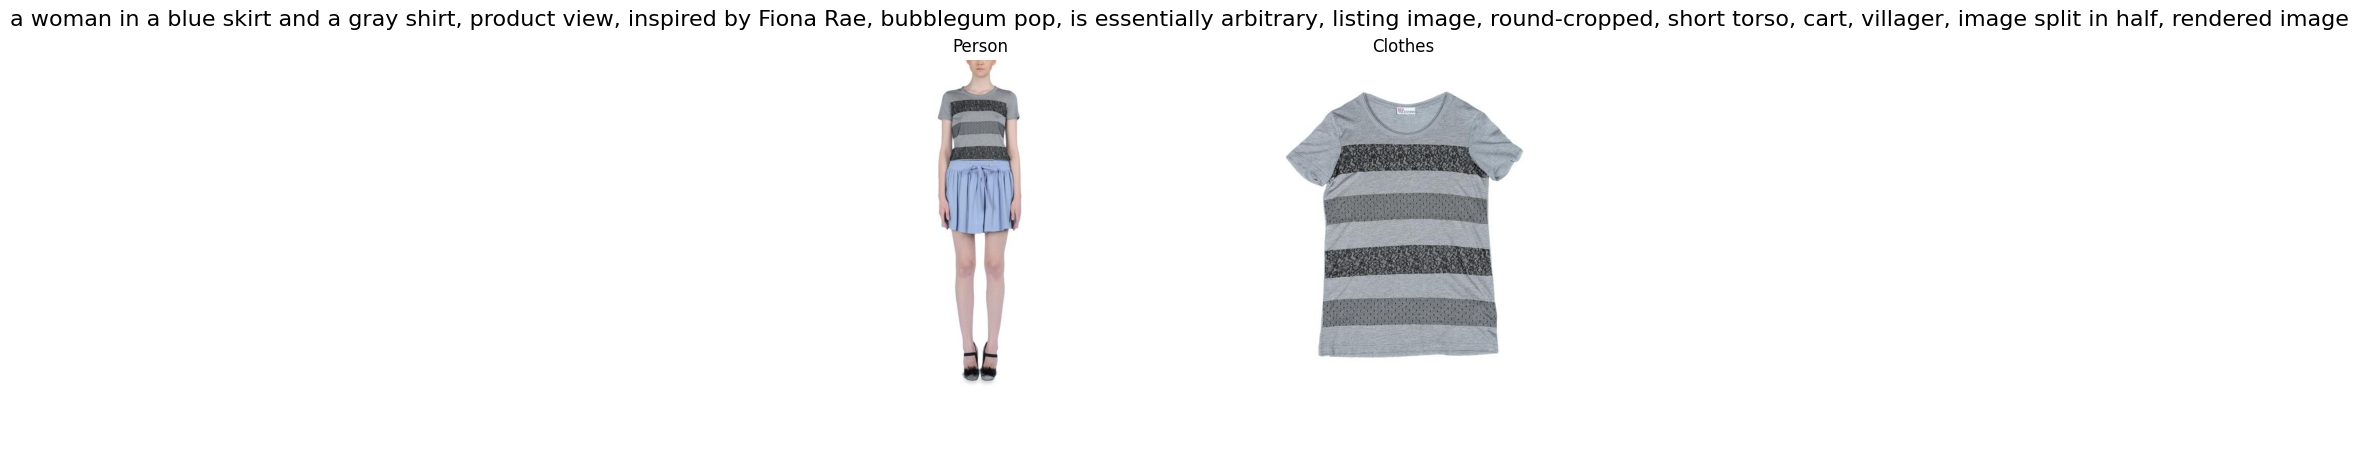


Filename: vitonhdtrain_upperbody_11996_00.jpg


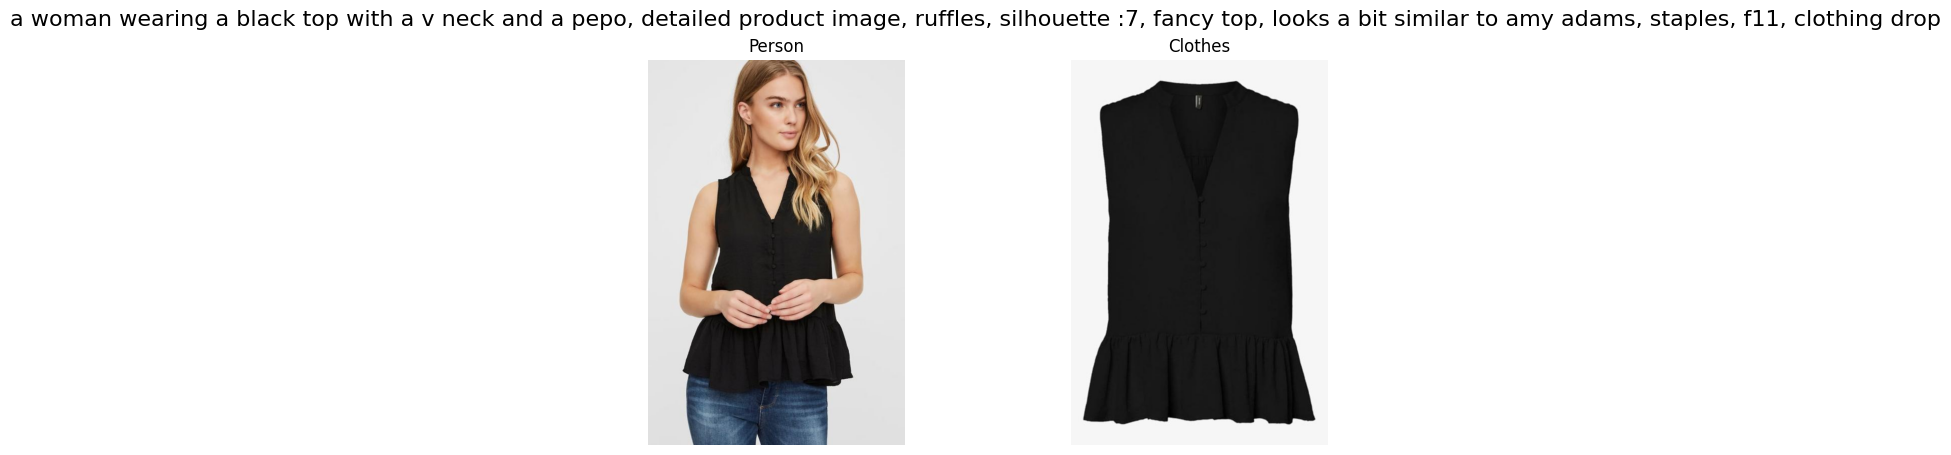


Filename: vitonhdtrain_upperbody_07161_00.jpg


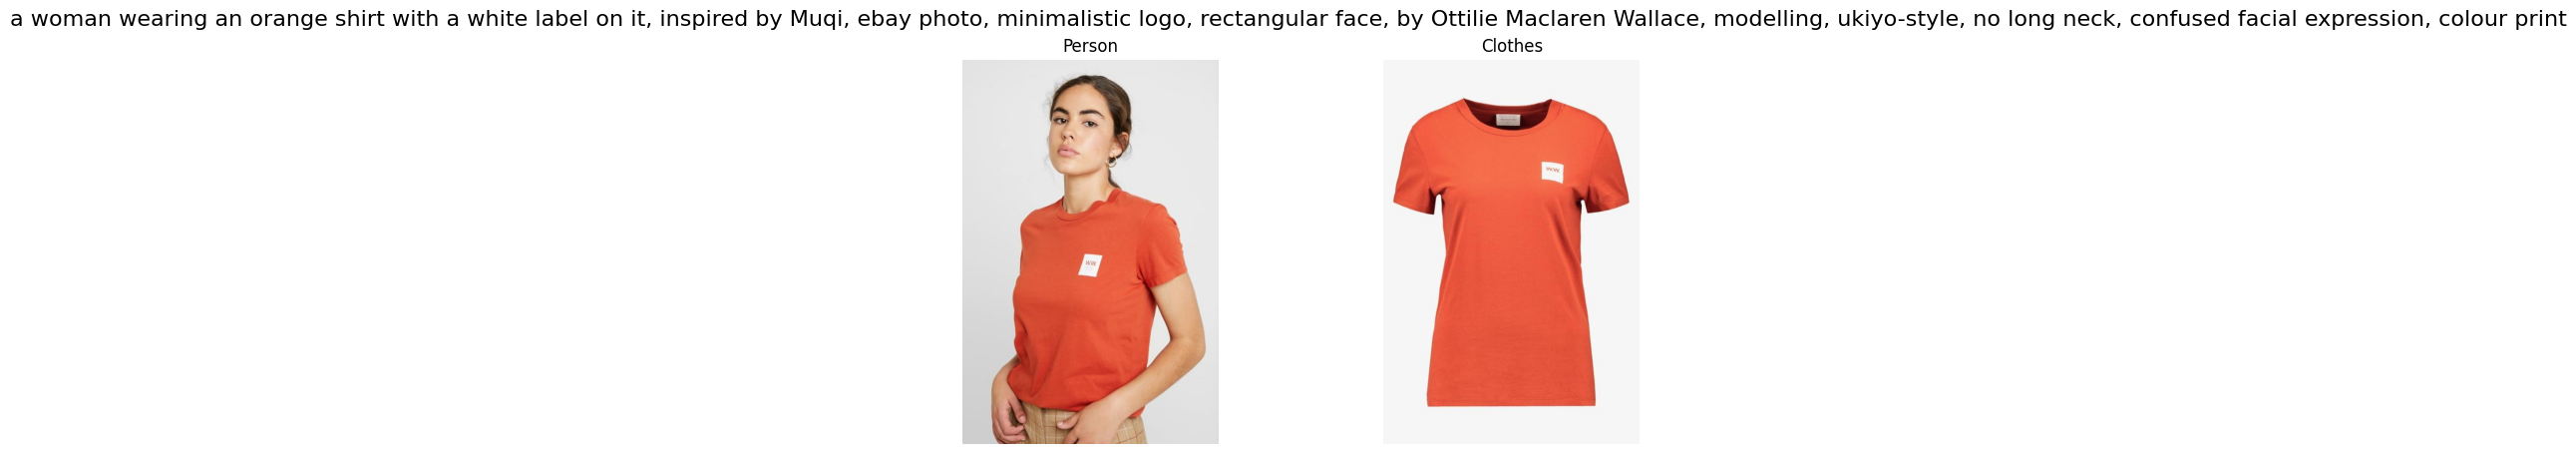


Filename: dresscode_lowerbody_015727.jpg


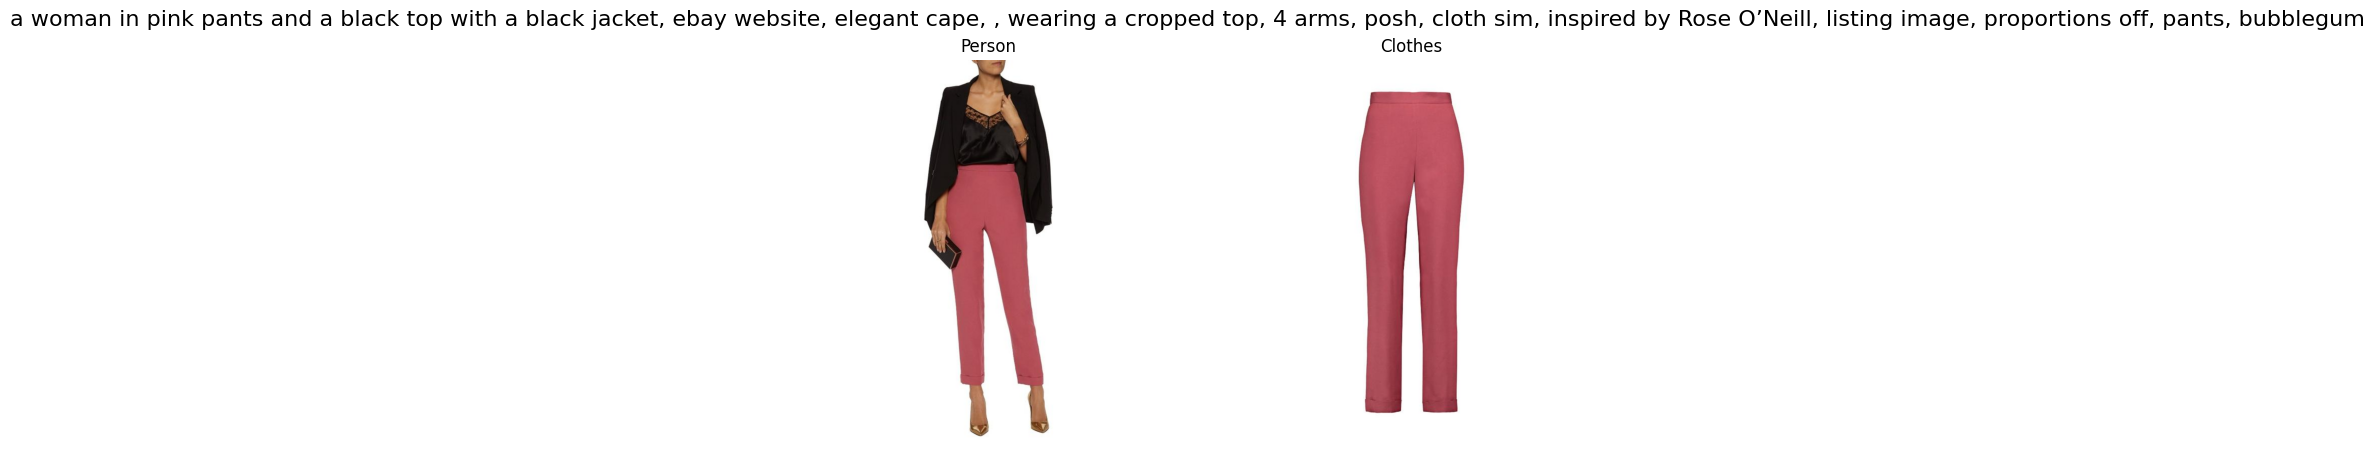


Filename: dresscode_upperbody_050092.jpg


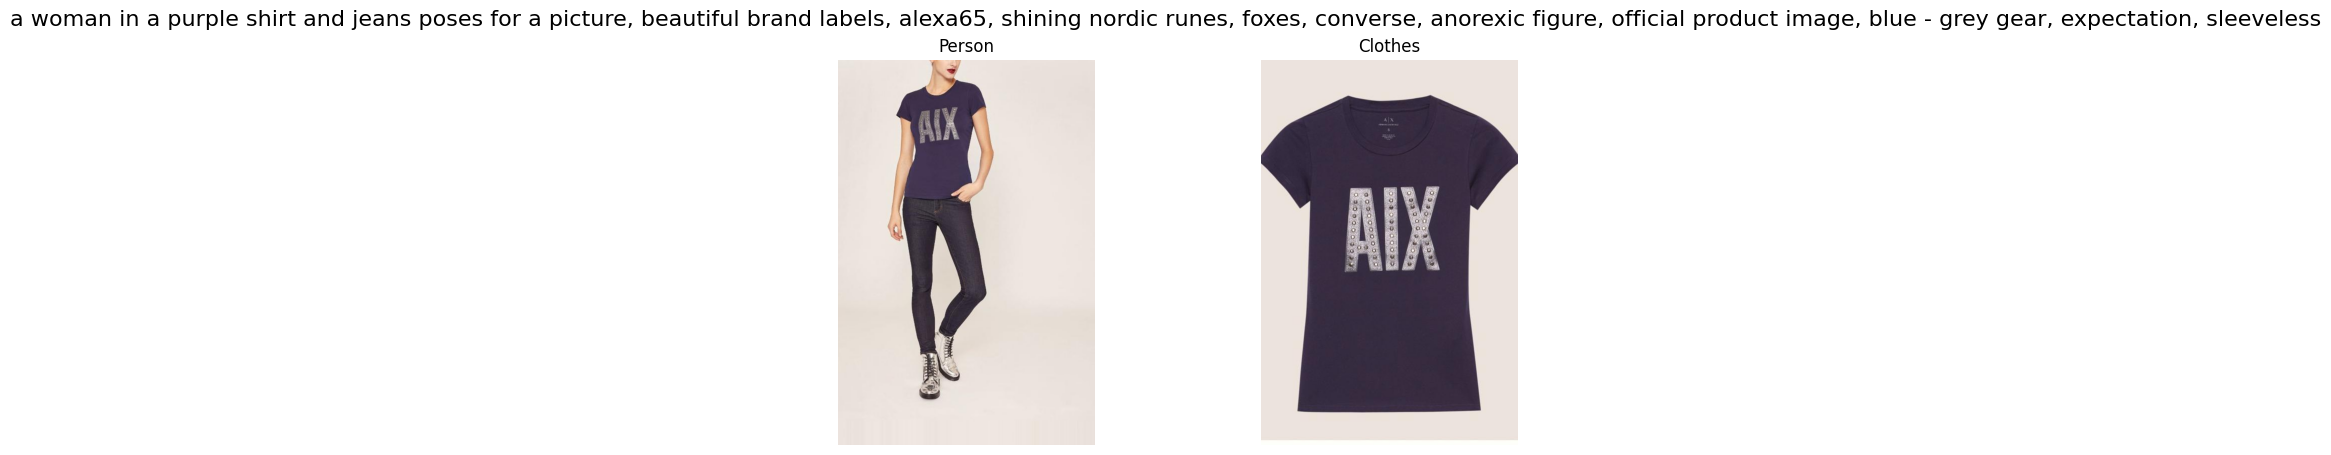


Filename: dresscode_dresses_037980.jpg


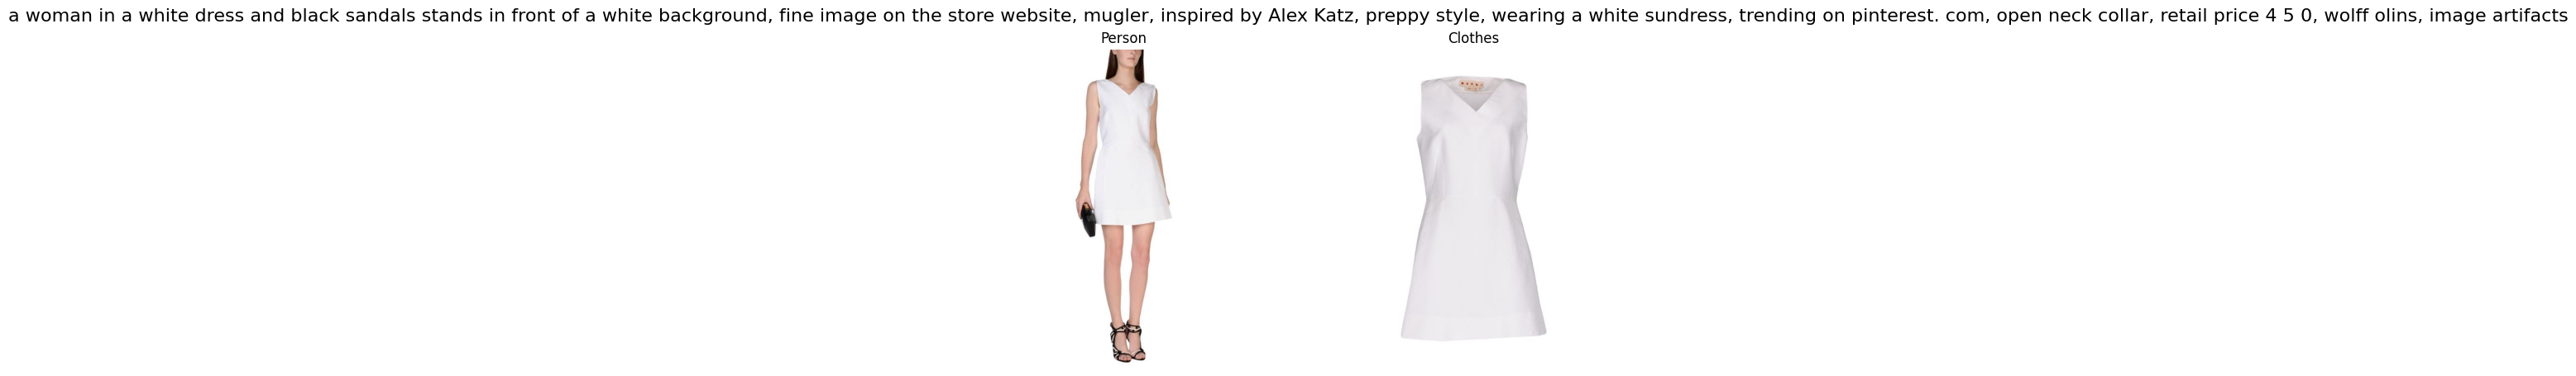

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
def display_with_caption(image_path, caption, filtered_captions=''):
    

    img1 = Image.open('dataset/persons/' + image_path)
    img2 = Image.open('dataset/clothes/' + image_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].set_title('Person')
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].set_title('Clothes')
    ax[1].axis('off')
    plt.suptitle(caption, fontsize=16)
    plt.show()
    print(filtered_captions)


for i in range(10):
    print("Filename:", captions['filename'].iloc[i])
    display_with_caption(captions['filename'].iloc[i], captions['caption'].iloc[i])

In [ ]:
# import ollama
# chat = lambda message: ollama.chat(model='phi3:14b-instruct', messages=[{'role': 'system', 'content': message}])['message']['content']
# chat('How are you')

In [ ]:
!pip install --upgrade pip
!pip install numpy==1.26.4 spacy==3.7.2 # fix not numpy 2.0
!python -m spacy download en_core_web_sm


In [23]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")
def get_chunks(text):
    doc = nlp(text)
    chunks = []
    current_chunk = []
    before = []
    prev_adp = None
    this_adp = None

    # preprocess text, when there is a "-" we take it as one word, e.g. "round-cropped" and type is of second word
    doc = [{'text': token.text, 'pos_': token.pos_} for token in doc]
    new_doc = []
    word_counter = 0
    for i, token in enumerate(doc):
        if i<word_counter:
            continue
        if len(doc)>i+2 and doc[i+1]['text'] == '-':
            new_doc.append({'text': doc[i]['text']+doc[i+1]['text']+doc[i+2]['text'], 'pos_': doc[i+2]['pos_']})
            word_counter += 3
        else:
            word_counter += 1
            new_doc.append({'text': token['text'], 'pos_': token['pos_']})

    doc = new_doc
    for i,token in enumerate(doc):
        # print(token.pos_,token.text)
        if token['pos_'] in ['DET', 'ADJ', 'NOUN' ,'PROPN']:
            current_chunk.append((token['pos_'],token['text']))
        else:
            if current_chunk:
                
                if before:
                    # if 'and' in before:
                    #     if prev_adp:
                    #         current_chunk.insert(0, prev_adp)
                   
                    current_chunk = before + current_chunk
                    
                
                # ap = " ".join(current_chunk)
                ap = current_chunk
                if ('CCONJ', 'and') in before:
                    if prev_adp:
                        # ap = (prev_adp, ap)
                        ap.insert(0, ('prev_adp',prev_adp))
                chunks.append(ap)
                current_chunk = []
                before = []
                prev_adp = this_adp
                this_adp = None
            
            # if token.pos_ in ['ADP', 'CCONJ', 'VERB', 'PUNCT', 'VERB ROOT','ADV', 'AUX ROOT', 'AUX']:
            before.append((token['pos_'],token['text']))
            if token['pos_'] in ['ADP', 'VERB ROOT', 'VERB']:
                this_adp = token['text']
    
    if current_chunk:
        if before:
            # if 'and' in before:
                # if prev_adp:
                    # current_chunk.insert(0, prev_adp)
            
            current_chunk = before + current_chunk
        ap = current_chunk
        if ('CCONJ', 'and') in before:
            if prev_adp:
                # ap = (prev_adp, ap)
                ap.insert(0, ('prev_adp',prev_adp))
        chunks.append(ap)
    elif before: # edge case only non-'DET', 'ADJ', 'NOUN' ,'PROPN' etc.. E.g. text only "round-cropped".
        chunks.append(before)
    
    return chunks

chunks = get_chunks("a woman in a white dress and black sandals stands in front of a white background")
for chunk in chunks:
    print(chunk)

# chunks = get_chunks("suki with a round-cropped neckline and a floral print")
# for chunk in chunks:
#     print(chunk)

[('DET', 'a'), ('NOUN', 'woman')]
[('ADP', 'in'), ('DET', 'a'), ('ADJ', 'white'), ('NOUN', 'dress')]
[('prev_adp', 'in'), ('CCONJ', 'and'), ('ADJ', 'black'), ('NOUN', 'sandals')]
[('VERB', 'stands'), ('ADP', 'in'), ('NOUN', 'front')]
[('ADP', 'of'), ('DET', 'a'), ('ADJ', 'white'), ('NOUN', 'background')]


--> Simplified rule: When prev_adp in block and last block is filtered out, remove the CCONJ and leave the prev_adp, else the other way around: "a woman in a dress and black sandals" -> "a woman in black sandals"<br><br>
--> Simplified rule: Check whether two adjacent blocks have higher probability of corresponding to the image e.g. "in a dress", "in a dress with a floral pattern" to also remove the second block <br><br>
--> Simplified rule: when previous ends with 'ADJ' or 'ADV' or 'VERB ROOT' and next starts with CCONJ and ADJ -> join them e.g. "a blue and white dress" <> "a blue hat and white dress"

In [25]:
# Apply: --> Simplified rule: when previous ends with 'ADJ' or 'ADV' or 'VERB ROOT' and next starts with CCONJ and ADJ -> join them e.g. "a blue and white dress" <> "a blue hat and white dress"
def chunk_with_rules(text):
    chunks = get_chunks(text)
    new_chunks = []
    last_was_joined_with_this = False
    for i in range(len(chunks)-1):
        if last_was_joined_with_this:
            last_was_joined_with_this = False
            continue
        current_chunk = chunks[i]
        next_chunk = chunks[i + 1]
        if current_chunk[-1][0] in ['ADJ','ADV','VERB ROOT'] and (next_chunk[0][0] == 'CCONJ'  or next_chunk[0][0] =='prev_adp' and next_chunk[1][0] == 'CCONJ'  ):
            if next_chunk[0][0] == 'prev_adp':
                new_chunks.append(current_chunk + next_chunk[1:])
            else:
                new_chunks.append(current_chunk + next_chunk)
            last_was_joined_with_this = True
        else:
            last_was_joined_with_this = False
            new_chunks.append(current_chunk)
    try:
        if not last_was_joined_with_this:
            new_chunks.append(chunks[-1])
    except BaseException as e:
        print(e, chunks, text)
    return new_chunks
    

In [118]:
get_chunks("a woman in white jeans and a sequin top posing for a picture")

[[('DET', 'a'), ('NOUN', 'woman')],
 [('ADP', 'in'), ('ADJ', 'white'), ('NOUN', 'jeans')],
 [('prev_adp', 'in'),
  ('CCONJ', 'and'),
  ('DET', 'a'),
  ('ADJ', 'sequin'),
  ('NOUN', 'top')],
 [('VERB', 'posing'), ('ADP', 'for'), ('DET', 'a'), ('NOUN', 'picture')]]

In [119]:
chunk_with_rules("a woman in white jeans and a sequin top posing for a picture")

[[('DET', 'a'), ('NOUN', 'woman')],
 [('ADP', 'in'), ('ADJ', 'white'), ('NOUN', 'jeans')],
 [('prev_adp', 'in'),
  ('CCONJ', 'and'),
  ('DET', 'a'),
  ('ADJ', 'sequin'),
  ('NOUN', 'top')],
 [('VERB', 'posing'), ('ADP', 'for'), ('DET', 'a'), ('NOUN', 'picture')]]

In [26]:
chunk_with_split_and_rules = lambda text: [chunk_with_rules(t) for t in text.split(',')]
for i in range(10):
    print("Filename:", captions['filename'].iloc[i])
    print('Captions:', captions['caption'].iloc[i])
    chunks = chunk_with_split_and_rules(captions['caption'].iloc[i])
    for chunk in chunks:
        for minichunk in chunk:
            tag = ' '.join([m[1] for m in minichunk])
            print(tag)

Filename: dresscode_dresses_033203.jpg
Captions: a woman in a blue and orange dress with a clutch, refracted line and sparkles, bold graphics, ultramarine metal, gown, suki, very tall and slender, barcodes, gliter, round-cropped, flat texture, galactic, palladium, product image
a woman
in a blue and orange dress
with a clutch
  refracted line
refracted and sparkles
  bold graphics
  ultramarine metal
  gown
  suki
  very tall and slender
  barcodes
  gliter
  round-cropped
  flat texture
  galactic
  palladium
  product image
Filename: vitonhdtrain_upperbody_09726_00.jpg
Captions: a woman wearing a white and black striped top and black leather skirt, anthro, minimalist photorealist, torso, t-top, pelisse, a new, features between french, inspired by James Baynes, flat icon, wearing : tanktop, oppai, cut out, very ahestetic
a woman
wearing a white and black striped top
and black leather skirt
  anthro
  minimalist photorealist
  torso
  t-top
  pelisse
  a new
  features
between french
 

In [58]:
# adapted from https://huggingface.co/docs/transformers/model_doc/clip
from PIL import Image
import requests
import torch

from transformers import CLIPProcessor, CLIPModel


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# url = "dataset/clothes/dresscode_dresses_033203.jpg"
# image = Image.open()

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1) 

NameError: name 'image' is not defined

In [37]:
logits_per_image.shape

torch.Size([1, 17])

In [71]:
remove_chunks

{'  gown',
 '  product image',
 '  ultramarine metal',
 '  very tall and slender',
 'in a blue and orange dress'}

Filename: dresscode_dresses_033203.jpg
Captions: a woman in a blue and orange dress with a clutch, refracted line and sparkles, bold graphics, ultramarine metal, gown, suki, very tall and slender, barcodes, gliter, round-cropped, flat texture, galactic, palladium, product image


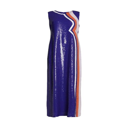

a woman                                            21.69
in a blue and orange dress                         24.37
with a clutch                                      19.53
  refracted line                                   22.21
refracted and sparkles                             21.73
  bold graphics                                    20.32
  ultramarine metal                                24.92
  gown                                             26.12
  suki                                             21.49
  very tall and slender                            25.72
  barcodes                                         20.03
  gliter                                           22.89
  round-cropped                                    22.45
  flat texture                                     23.08
  galactic                                         22.49
  palladium                                        19.71
  product image                                    25.13
in a blue and orange dress with

In [74]:
# with logits
# Similarity is learned in the paper using dot product, so we can use the logits directly: 
# logits = np.dot(I_e, T_e.T) * np.exp(t)
chunk_with_split_and_rules = lambda text: [chunk_with_rules(t) for t in text.split(',')]
for i in range(1):
    print("Filename:", captions['filename'].iloc[i])
    print('Captions:', captions['caption'].iloc[i])
    from PIL import Image
    img = Image.open('dataset/clothes/'+captions['filename'].iloc[i])
    chunks = chunk_with_split_and_rules(captions['caption'].iloc[i])

    all_chunks = [' '.join([m[1] for m in minichunk]) for chunk in chunks for minichunk in chunk]
    inputs = processor(text=all_chunks, images=img, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    display(img.resize((128,128)))
    normal_chunk_dict = {}
    for i, chunk in enumerate(all_chunks):
        normal_chunk_dict[chunk] = logits_per_image[0][i]
        print(f"{chunk:<50} {logits_per_image[0][i]:.2f}")


    # make adjacent chunks into one
    adjacent_chunks = []
    adjacent_chunk_parts = []
    for chunk in chunks:
        last_chunk = ''
        for minichunk in chunk:
            if not('boy' in last_chunk or 'girl' in last_chunk or 'man' in last_chunk or 'woman' in last_chunk) and not last_chunk=='' and not minichunk[0][1] == '':
                adjacent_chunks.append(last_chunk + ' '+ ' '.join([m[1] for m in minichunk]))
                adjacent_chunk_parts.append((last_chunk, ' '.join([m[1] for m in minichunk])))
            last_chunk = ' '.join([m[1] for m in minichunk])
            
    outputs = model(**inputs)
    with torch.no_grad():
        inputs = processor(text=adjacent_chunks, images=img, return_tensors="pt", padding=True)
    logits_per_image = outputs.logits_per_image

    adj_chunk_dict = {}
    for i, chunk in enumerate(adjacent_chunks):
        adj_chunk_dict[chunk] = {'v':logits_per_image[0][i],'keys':adjacent_chunk_parts[i]}
    
    for i, chunk in enumerate(adjacent_chunks):
        print(f"{chunk:<50} {logits_per_image[0][i]:.2f}")

    # removal of chunk logic:
    # remove every chunk v > 23.8
    
    adj_chunk_keys = list(adj_chunk_dict.keys())
    remove_chunks = set()
    remove_chunks_joined_keys = []
    threshold = 23.8
    for k, v in normal_chunk_dict.items():
        if k in remove_chunks or k == '':
            continue
        if v <threshold:
            continue 
        remove_chunks.add(k)
    # if the joined chunk (logit of two chunks joined) > 23.8, remove both chunks, but only when the joined logit is higher than the logit of each individual chunk
    # and only do this for the largest logit for each chunk
    for k, v in adj_chunk_dict.items():
        if v['v'] < threshold:
            continue
        k1, k2 = v['keys']
        bigger_keys = []
        if normal_chunk_dict[k1] > v['v']:
            bigger_keys.append(k1)
        if normal_chunk_dict[k2] > v['v']:
            bigger_keys.append(k2)
        if len(bigger_keys) == 0:
            continue
        
        is_biggest_logit_for_at_least_one = False
        for key in bigger_keys:
            keys_part_of2 = [ak for ak in adj_chunk_keys if k2 in ak]
            for k2_ in keys_part_of2:
                if adj_chunk_dict[k2_]['v'] > v['v']:
                    break
            is_biggest_logit_for_at_least_one = True
            break
        if is_biggest_logit_for_at_least_one:
            remove_chunks.add(k1)
            remove_chunks.add(k2)
            remove_chunks_joined_keys.append(k1+' '+k2)
            remove_chunks_joined_keys.append(k2+' '+k1)

    last_was_removed = False
    final_tag = ''
    for chunk in chunks:
        final_tag +=', '
        for minichunk in chunk:
            tag = ' '.join([m[1] for m in minichunk])
            if tag in remove_chunks:
                last_was_removed = True
            elif last_was_removed:
                final_tag = final_tag[:-2]
                last_was_removed = False
                final_tag += tag
            else:
                last_was_removed = False
                final_tag += tag

    final_tag = final_tag[2:]
    print('Final tag:', final_tag)
        # print(f"{chunk:<50} {logit:.2f}")
                    


            


We set the threshold at logits>23.8 after examining at 50 image. It is no perfect filter, e.g. especially for "white- and black tops" the logits are always low. 

In [63]:
adj_chunk_dict[k2]['keys']

('', '  ruffles')

In [ ]:
# Similarity is learned in the paper using dot product, so we can use the logits directly: 
# logits = np.dot(I_e, T_e.T) * np.exp(t)
outputs.text_embeds.shape, outputs.image_embeds.shape

In [ ]:
for i in range(10):
    print("Filename:", captions['filename'].iloc[i])
    display_with_caption(captions['filename'].iloc[i], captions['caption'].iloc[i])

In [38]:
captions['caption'].iloc[i]

'a woman in a white dress and black sandals stands in front of a white background, fine image on the store website, mugler, inspired by Alex Katz, preppy style, wearing a white sundress, trending on pinterest. com, open neck collar, retail price 4 5 0, wolff olins, image artifacts'

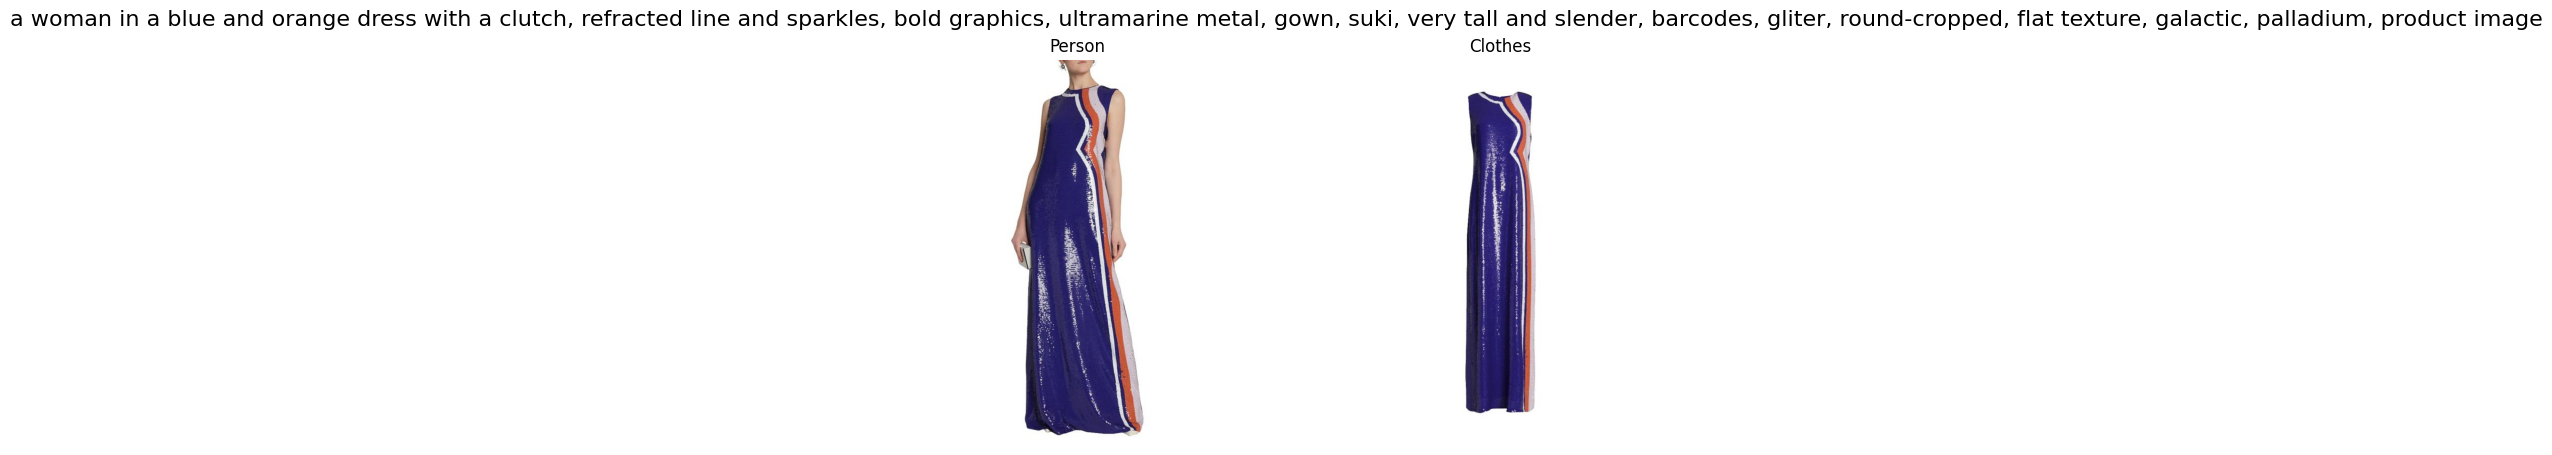

 blue dress, orange dress, clutch bag, bold graphic, evening gown, glittery fabric, sparkles, metallic accents, tall silhouette, slender figure.


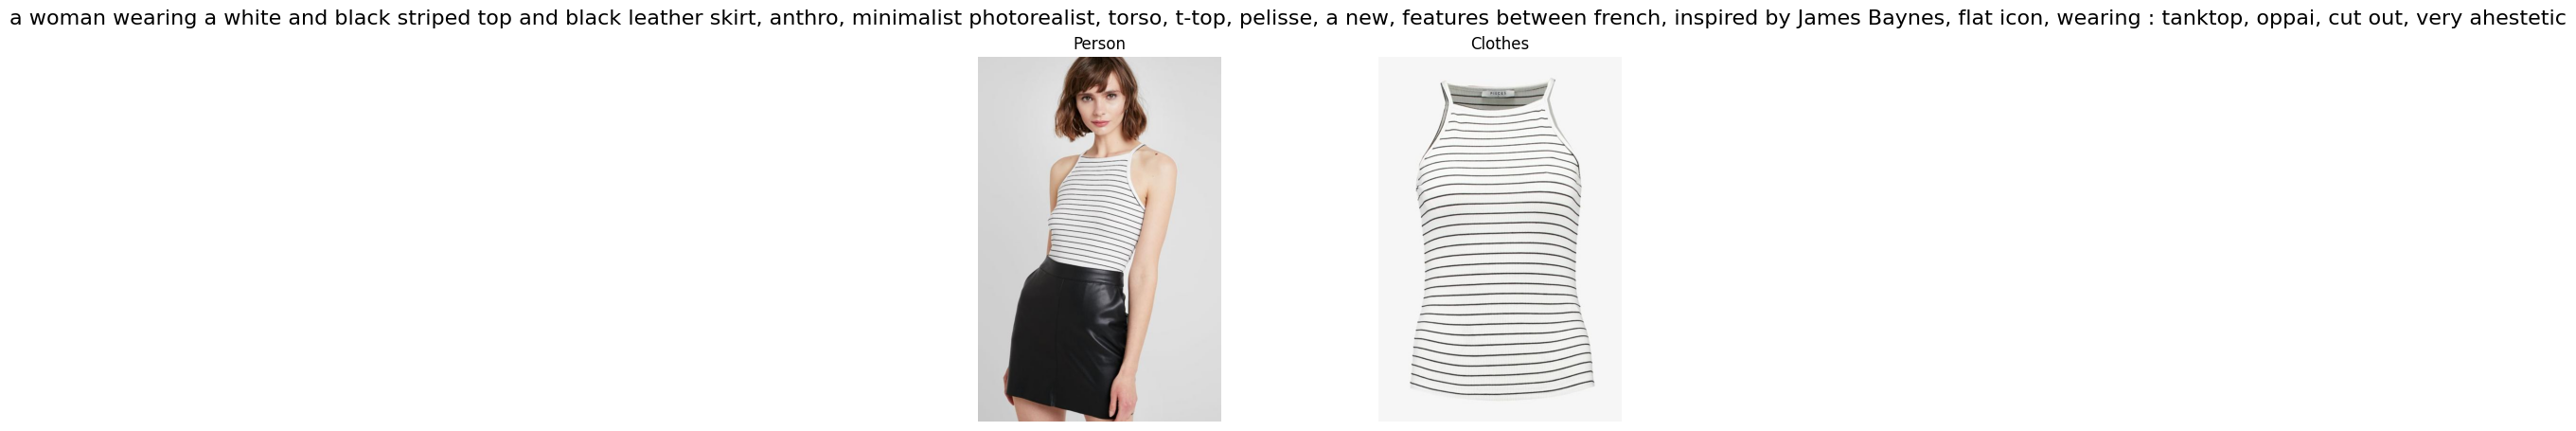

 striped top, skirt, upper-body clothes, anthro, photorealist


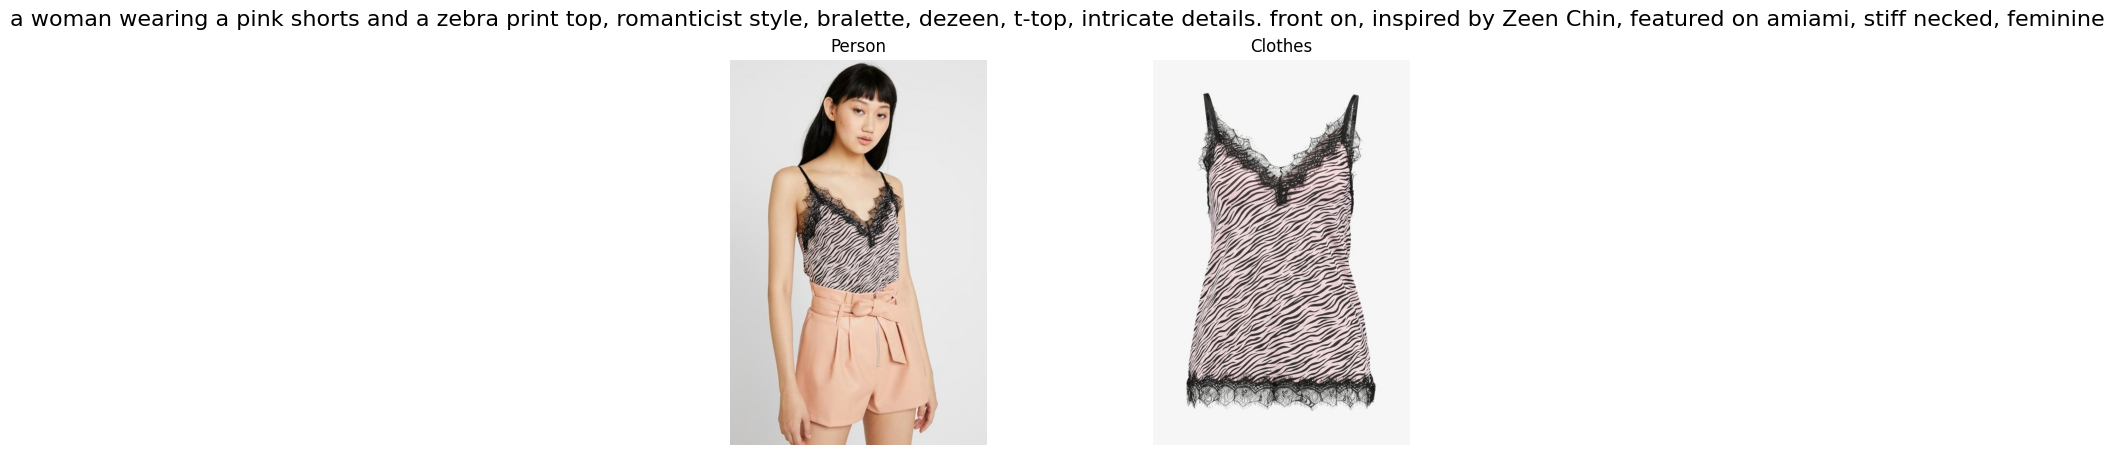

 - Zebra print top
- Bralette
- Romanticist style
- Feminine upper wear


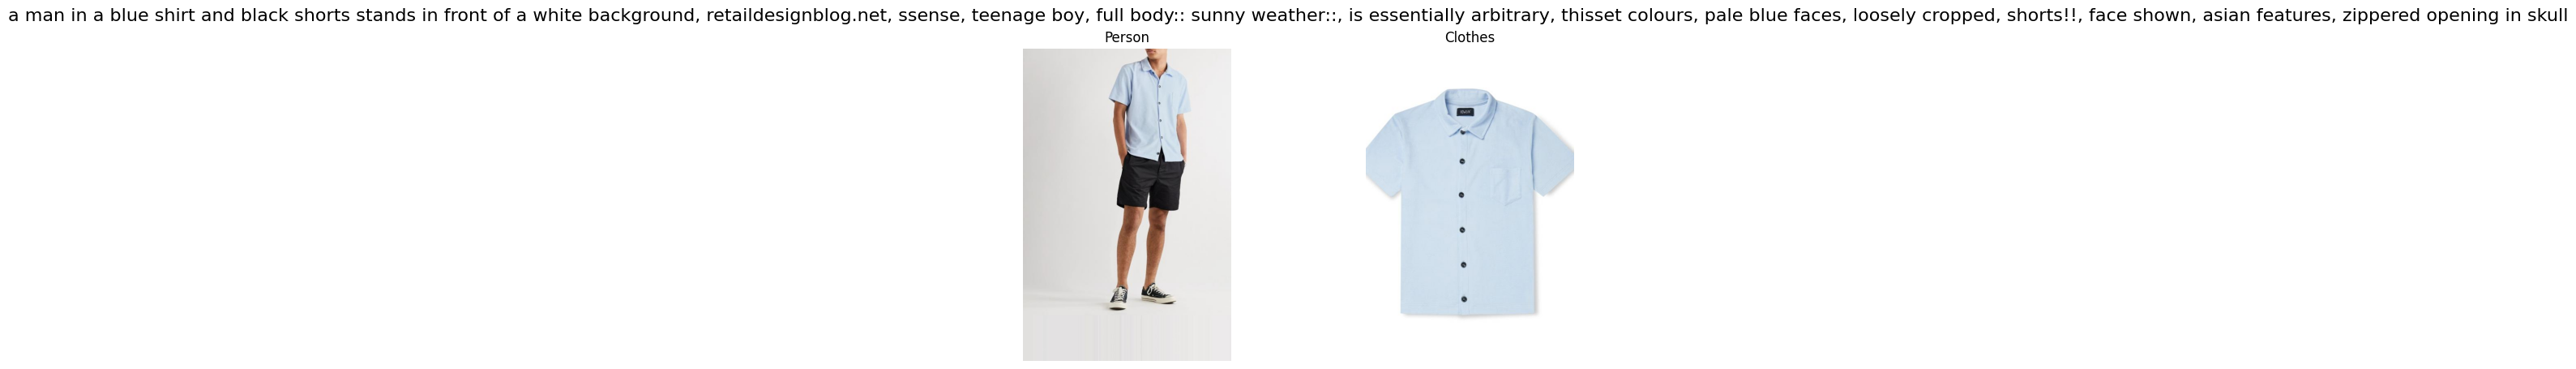

 Man in blue shirt, black shorts, upper-body clothes, casual wear, teenage boy attire, sunny weather clothing, loose fit, pale blue top, Asian style


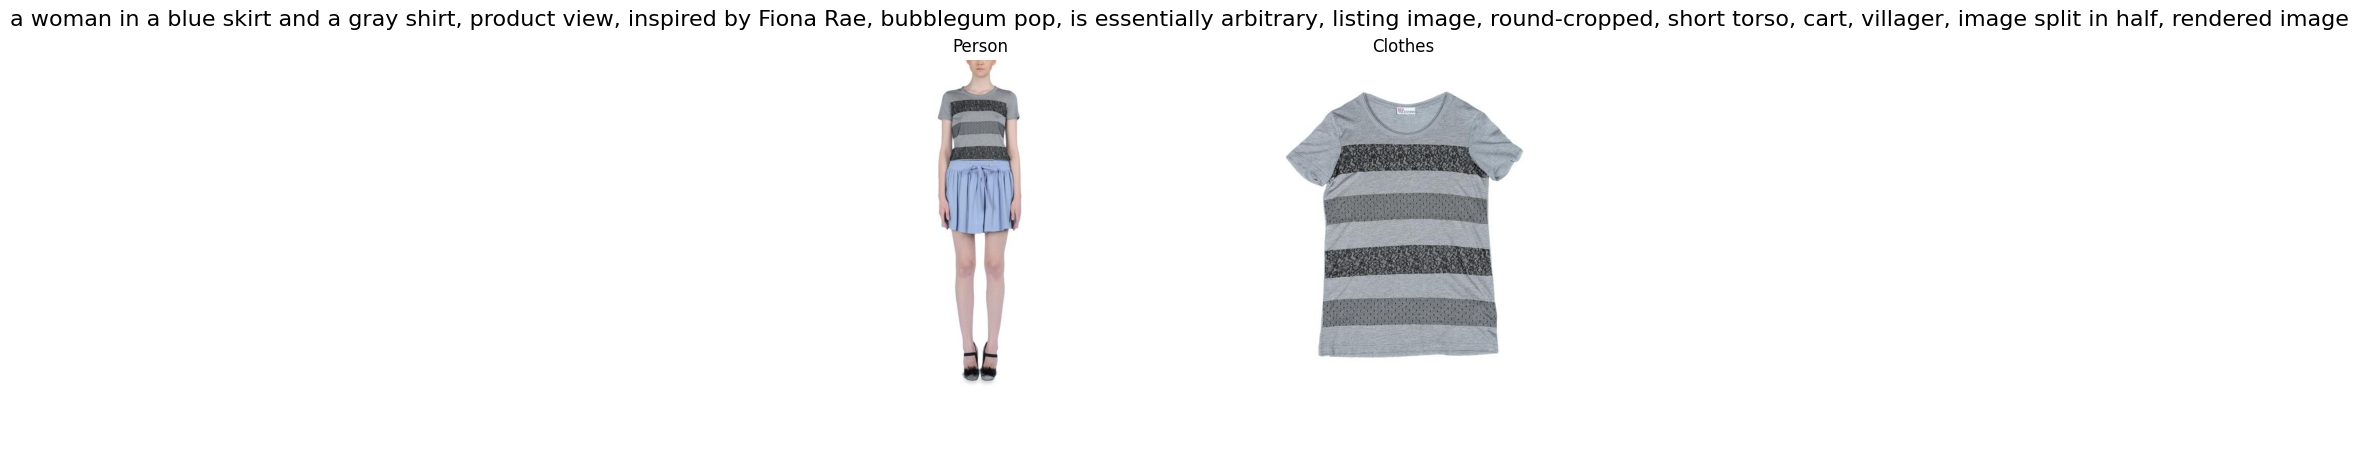

 "gray shirt", "blue skirt upper part"


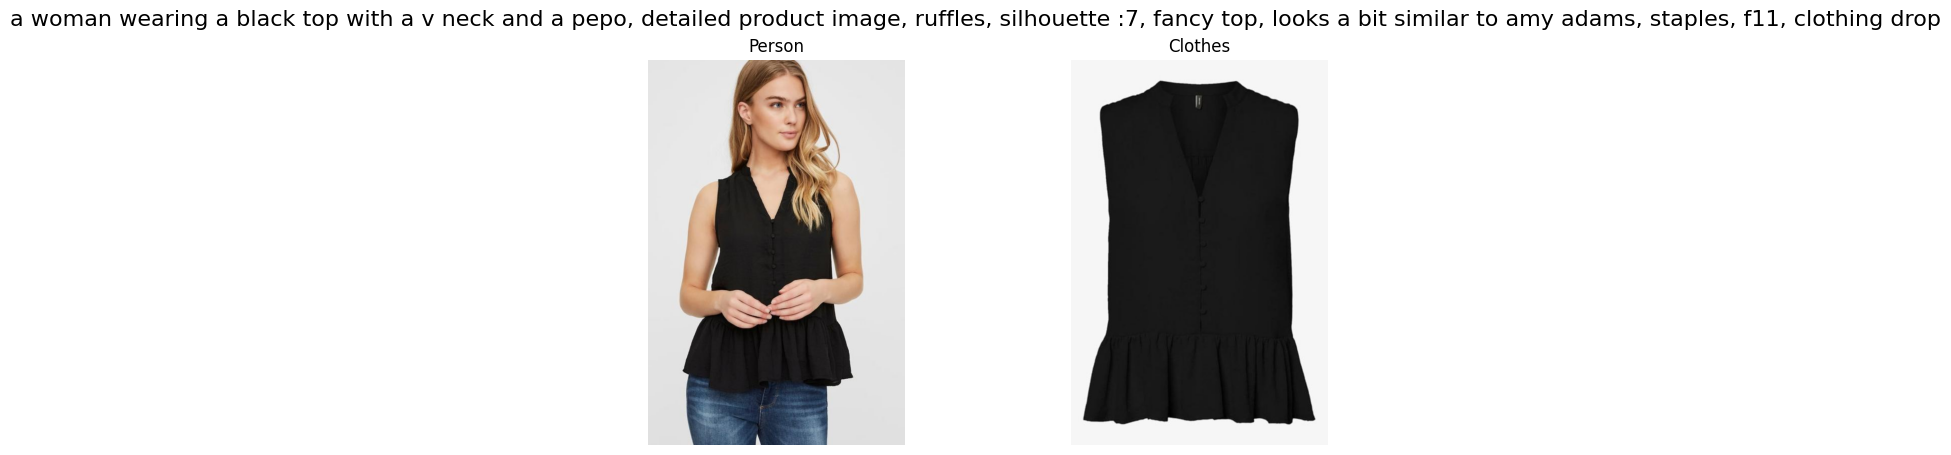

 women'ebodywear, blacktop, vneck, ruffles, silhouette, fancytop, upperbodyclothes


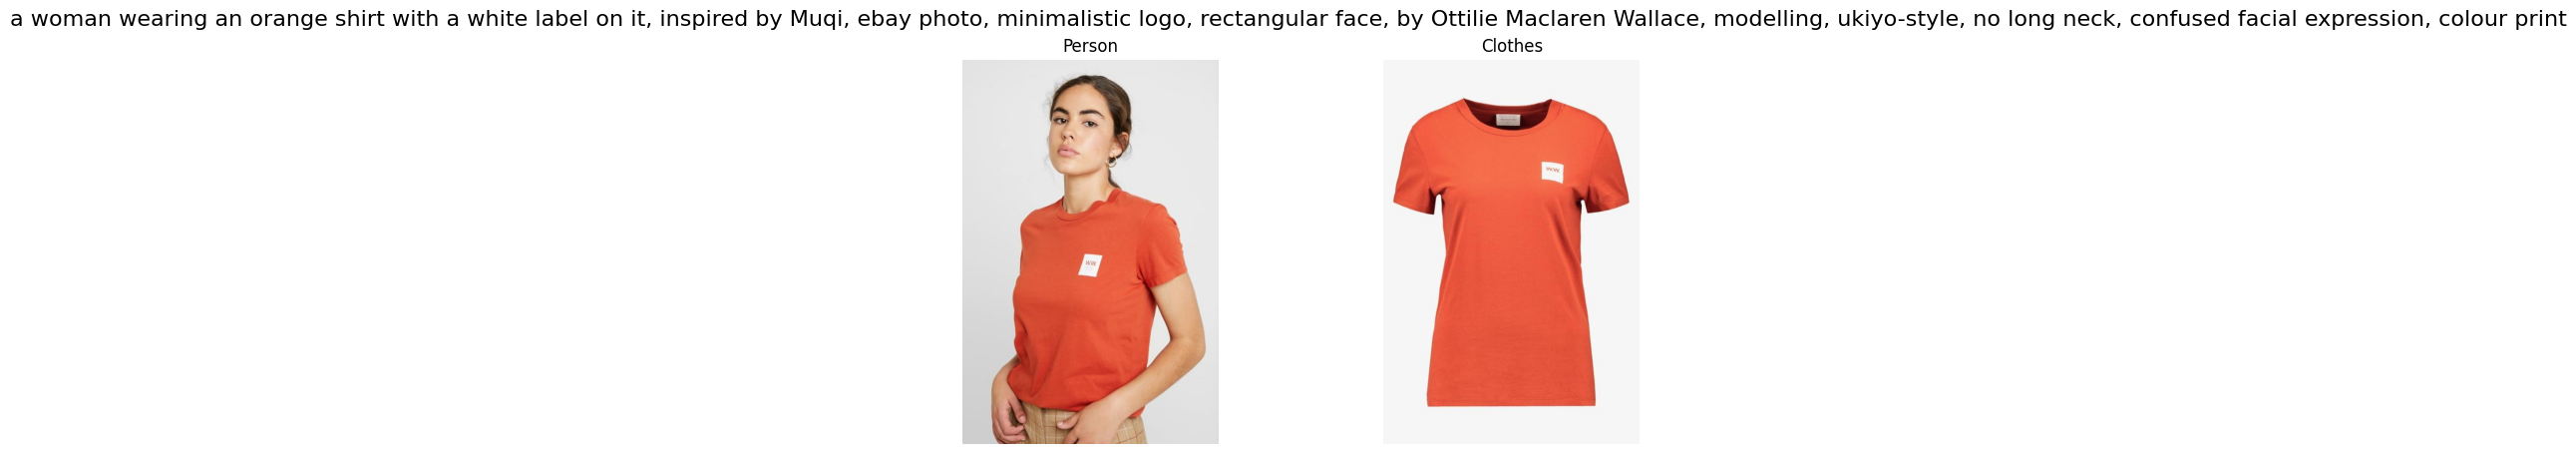

 orange shirt, upper-body clothes, white label on clothing, modeling attire, minimalistic logo apparel.


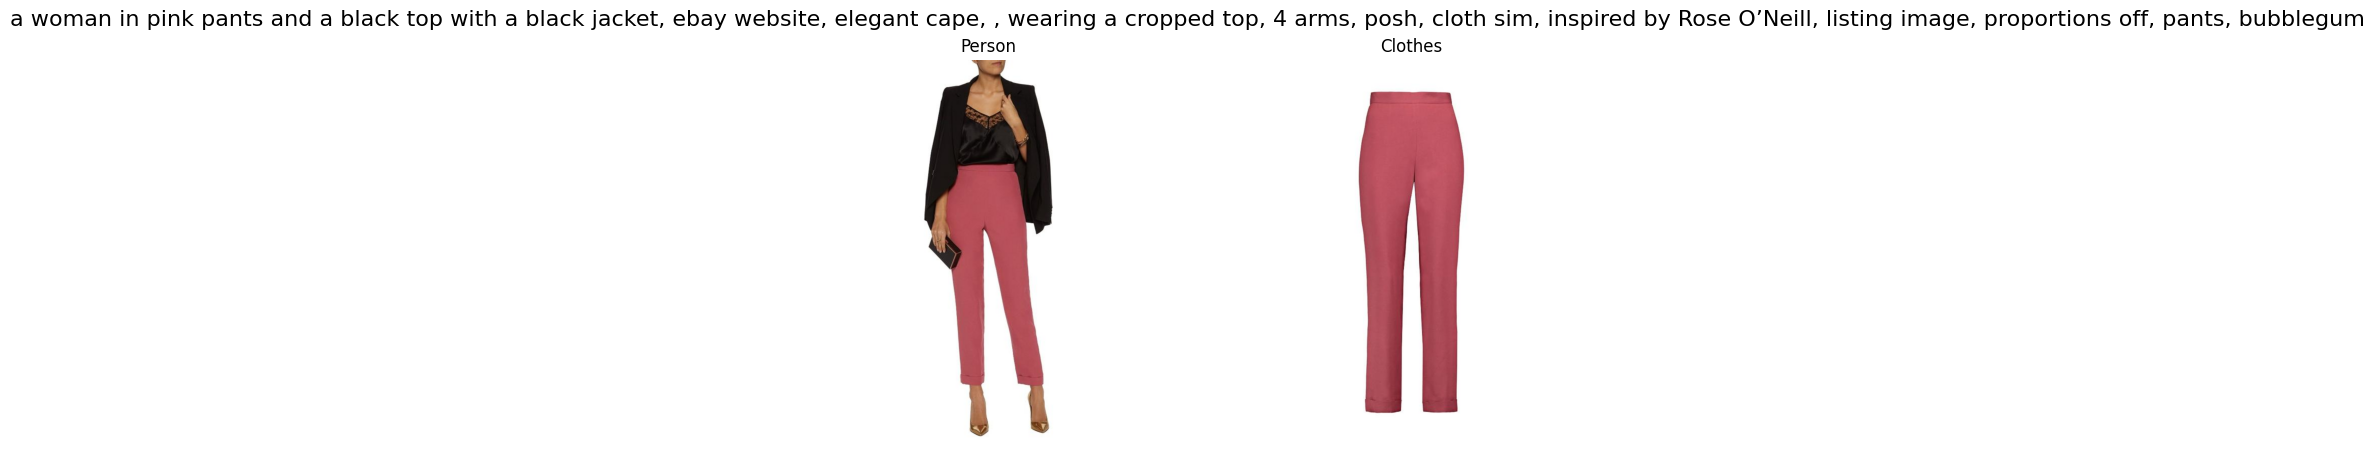

 - woman in pink pants
- black jacket
- elegant crop top
- pants
- cloth simulation


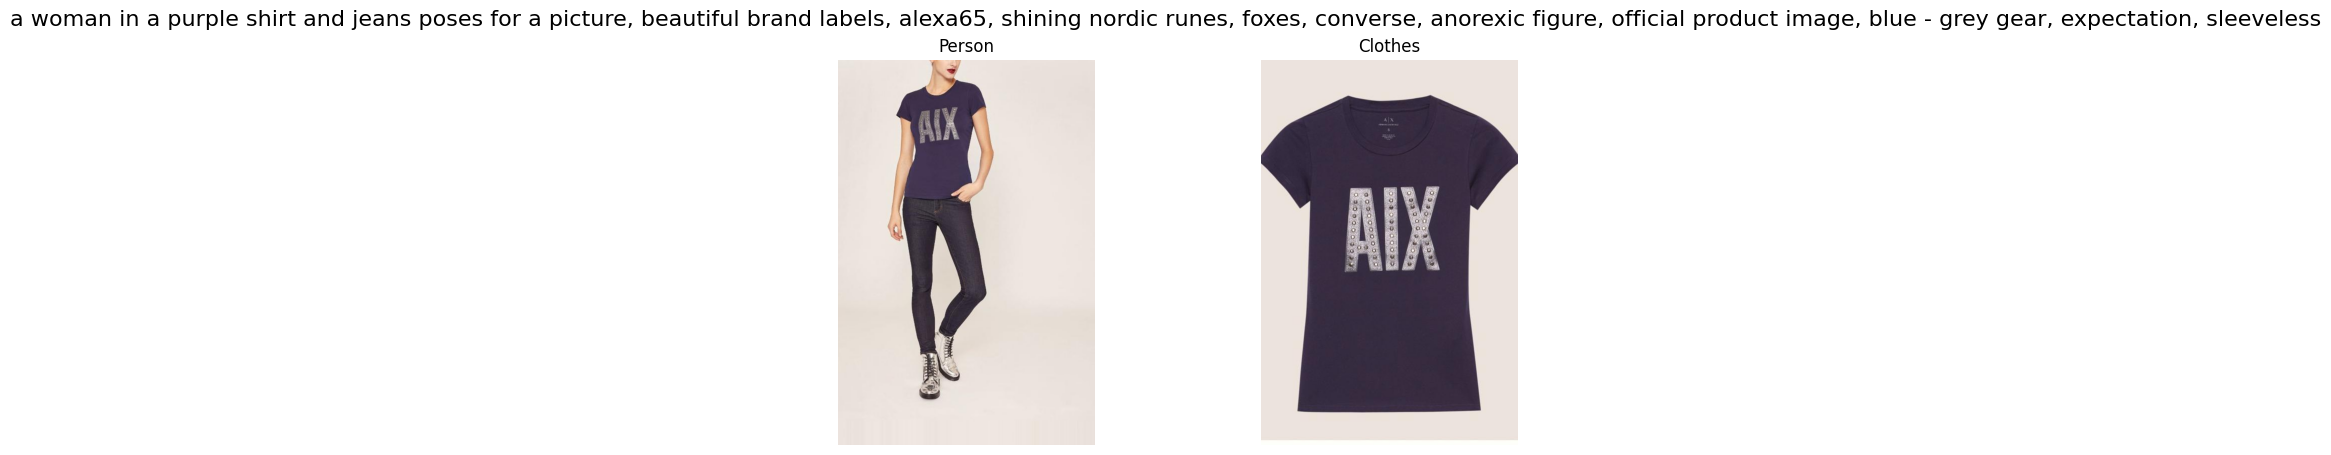

 purple shirt, jeans, sleeveless, women's upper-body clothing


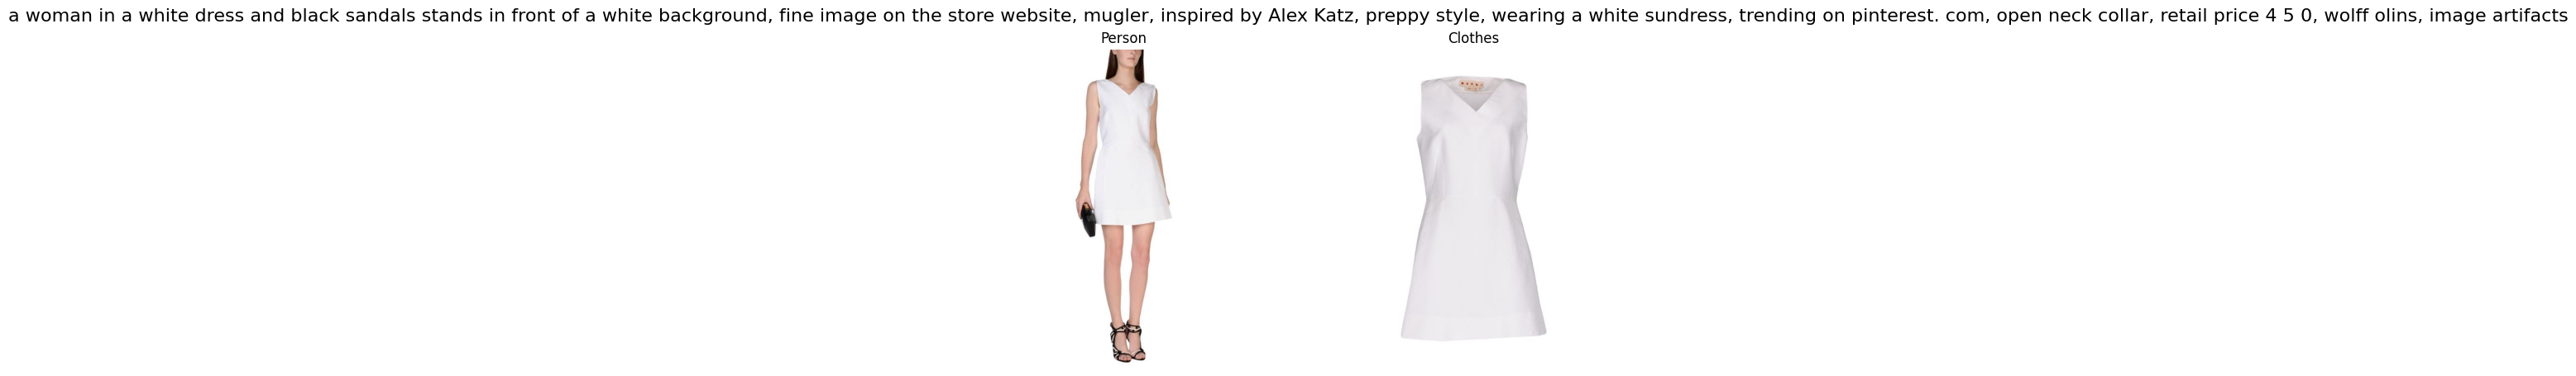

 - woman in white dress
- black sandals
- white background
- mugler inspired
- preppy style
- white sundress
- open neck collar


In [30]:
for i in range(10):
    cap = captions['caption'].iloc[i]
    clothing_type = captions['filename'].iloc[i].split('_')[1]
    if clothing_type == 'dresses':
        instruct = 'You are creating tags for an image. Which tags are related to or describe the dress the person wears?'
    elif clothing_type == 'lowerbody':
        instruct = 'You are creating tags for an image. Which tags are related to or describe the lower-body clothes the person wears?'
    elif clothing_type == 'upperbody':
        instruct = 'You are creating tags for an image. Which tags are related to or describe the upper-body clothes the person wears?'
    instruct += ' Only return the tags which describe these. Here are the original tags: ' + cap + '. Please return the tags.'
    
    
    filtered_captions = chat(instruct)
    display_with_caption(captions['filename'].iloc[i], captions['caption'].iloc[i], filtered_captions)